# Анализ оттока клиентов

**Описание проекта:**

**Необходимо проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка**

## Импортируем библиотеки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st

## Откроем таблицу и изучим общую информацию о данных

In [2]:
df = pd.read_csv("D:/DA/projects/bank_scrooge.csv")

### Выведим первые 10 строк

In [3]:
df.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0


**Приведем названия столбцов к единому варианту с нижним регистром**

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.sample()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2229,169121,920.0,Рыбинск,Ж,60,0,NaN,1,0,0,655602.65,0


### Описание данных

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — приблизительная оценка собственности клиента,
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — был ли клиент активен последнее время,
- est_salary — заработная плата клиента
- churn — уходит или нет.

### Изучим датасет при помощи info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


**Видим, что в данных 10 000 строк, 12 столбцов и есть пропуски в данных о балансе. Типы данных в принципе соответствуют, не будем менять**

## Предобработка данных

### Проверим на наличие пропусков

In [7]:
df.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
userid,0.00%
score,0.00%
city,0.00%
gender,0.00%
age,0.00%
equity,0.00%
products,0.00%
credit_card,0.00%
last_activity,0.00%
est_salary,0.00%


**В столбце баланс пропущено почти 23% данных. Попытаемся разобраться**

`Создадим копию датасета для проверки пропусков`

In [8]:
df_balance = df.copy()

**Преобразуем столбец balance в balance_check:**
- 0 - Это пропущенные значения
- 1 - Есть значение

In [9]:
df_balance['balance_check'] = df_balance['balance'].apply(lambda x: 1 if x >=0 else 0)

**Посмотрим медианные значения сгруппировав по balance_check**

In [10]:
df_balance.groupby('balance_check').agg('median')

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
balance_check,,,,,,,,,,
0,172659.0,903.0,39.0,0.0,NaN,1.0,1.0,1.0,174160.68,0.0
1,172740.0,840.0,40.0,4.0,524272.2,2.0,1.0,1.0,106222.20,0.0


**Посмотрим средние значения сгруппировав по balance_check**

In [11]:
df_balance.groupby('balance_check').agg('mean')

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
balance_check,,,,,,,,,,
0,172069.447930,865.35207,41.849237,0.050980,NaN,1.162092,0.815686,0.549455,226310.208654,0.005664
1,171738.837508,843.73926,43.131343,3.395068,827794.30651,2.086178,0.640104,0.515769,124501.872366,0.234783


**Вывод: Видим, что многие показатели не сильно различаются, но есть пара моментов. Во первых это оценка собственности, у пропущенных значений она нулевая. Значит это клиенты без ипотеки и автокредита. Возможно это клиенты с потребительским кредитом. Во вторых у клиентов с отсутствием баланса 1 банковский продукт, а у остальных 2.
Возможно на эти счета наложен судебный арест. Но четкого ответа по поводу происхождения пропусков дать нельзя, поэтому оставим эти данные в таком виде, ничего удалять или заменять не будем. В дальнейшем попробуем рассмотреть этих клиентов поподробнее.**

### Проверим на наличие дубликатов

In [12]:
print(f'Всего {df.duplicated().sum()} дубликат')

Всего 1 дубликат


**Удалим дубликат**

In [13]:
df = df.drop_duplicates()

## Исследовательский анализ

`Создадим копию датасета для исследовательского анализа`

In [14]:
df_eda = df.copy()

### Изучим столбец с баллами кредитного скоринга score

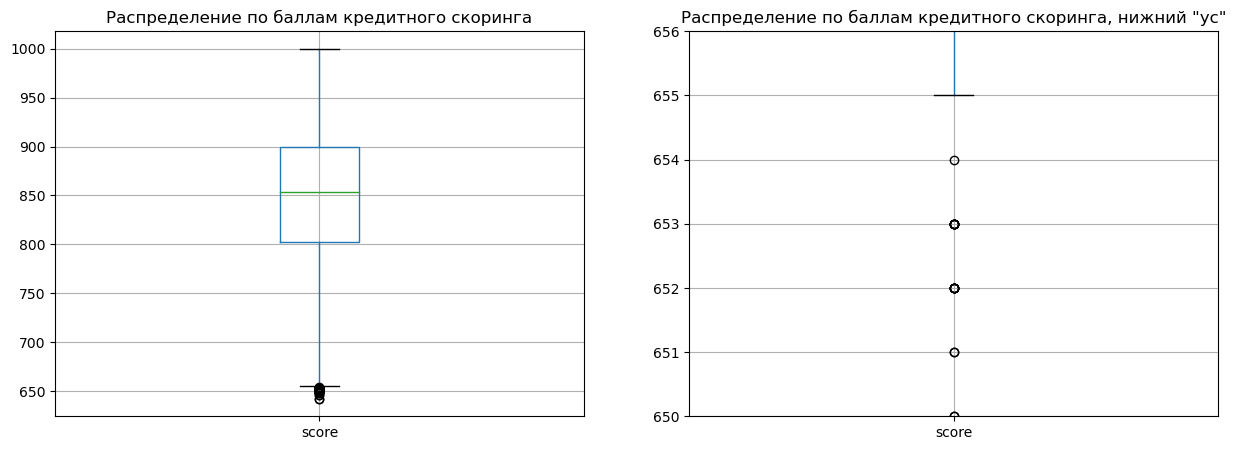

In [15]:
plt.figure(figsize=(15, 5))

ax1=plt.subplot(1, 2, 1)
df_eda.boxplot('score')
plt.title('Распределение по баллам кредитного скоринга')

ax2=plt.subplot(1, 2, 2)
df_eda.boxplot('score')
plt.ylim(650, 656)
plt.title('Распределение по баллам кредитного скоринга, нижний "ус"')

plt.show()

In [16]:
df_eda['score'].describe()

count    9999.000000
mean      848.691369
std        65.446864
min       642.000000
25%       802.000000
50%       853.000000
75%       900.000000
max      1000.000000
Name: score, dtype: float64

- Медианное значение score = 853
- По графику видим, что ниже 655 баллов начинаются выбросы.

**Очистим данные от выбросов**

In [17]:
df_eda = df_eda.loc[df_eda['score'] > 654]

### Изучим столбец с городами city

In [18]:
df_eda['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

**Видим, что в данных представлено 3 города Ярославской области: Ярославль, Рыбинск и Ростов**

### Изучим столбец с гендерными различиями gender

In [19]:
df_eda['gender'].unique()

array(['Ж', 'М'], dtype=object)

**Видим понятные две буквы:**
- М = Мужской пол
- Ж = Женский пол

### Изучим столбец с возрастом клиентов age

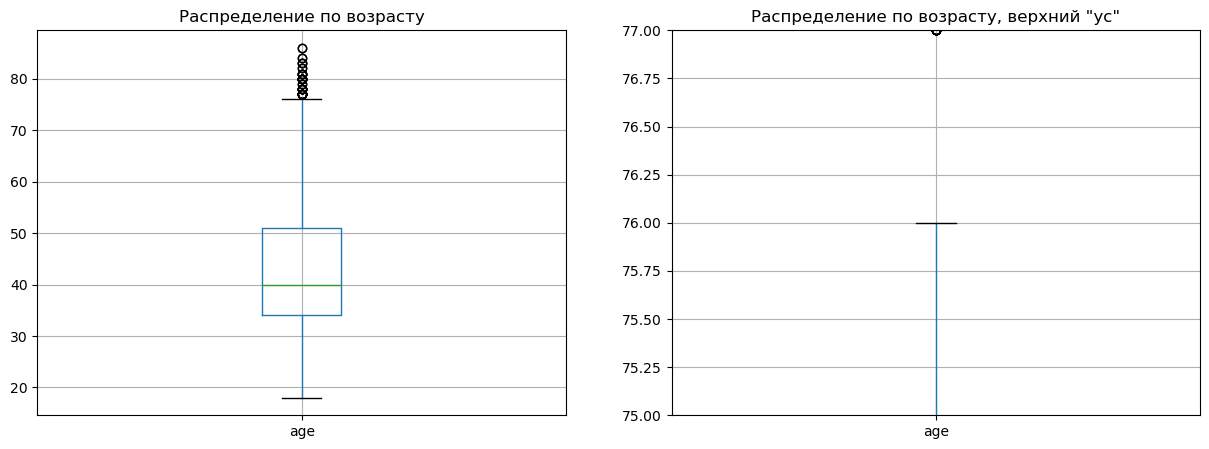

In [20]:
plt.figure(figsize=(15, 5))

ax1=plt.subplot(1, 2, 1)
df_eda.boxplot('age')
plt.title('Распределение по возрасту')

ax2=plt.subplot(1, 2, 2)
df_eda.boxplot('age')
plt.ylim(75, 77)
plt.title('Распределение по возрасту, верхний "ус"')
plt.show()

In [21]:
df_eda['age'].describe()

count    9966.000000
mean       42.831728
std        12.127111
min        18.000000
25%        34.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

- Медианное значение age = 40 лет
- Минимальное значение 18 лет
- Максимальное значение 86 лет
- По графику видим, что после 76 начинаются выбросы

### Изучим столбец с оценкой собственности equity

In [22]:
df['equity'].unique()

array([1, 5, 0, 4, 3, 2, 6, 7, 8, 9], dtype=int64)

**Видим шкалу оценок от 0 до 9**

### Изучим столбец с балансом balance

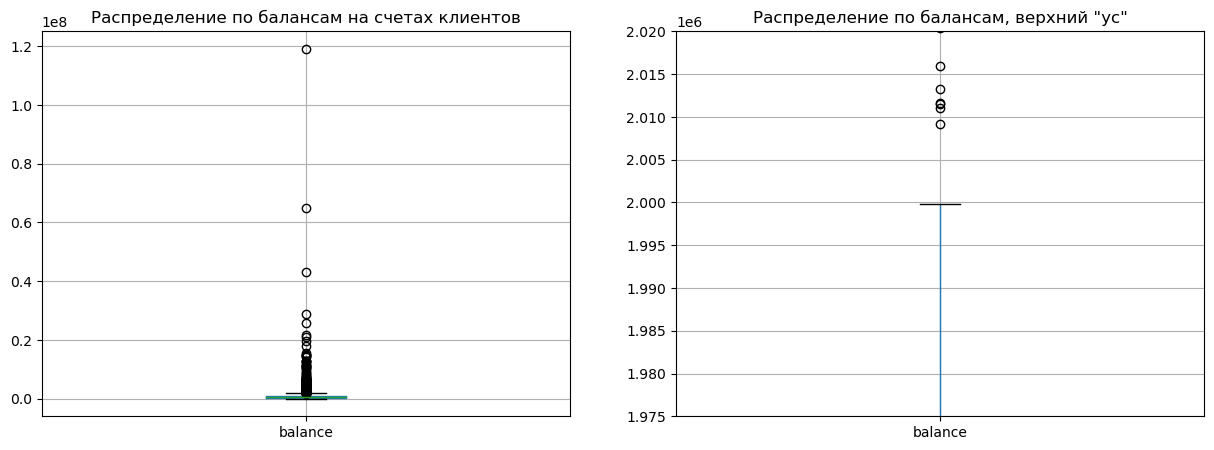

In [23]:
plt.figure(figsize=(15, 5))

ax1=plt.subplot(1, 2, 1)
df_eda.boxplot('balance')
plt.title('Распределение по балансам на счетах клиентов')

ax2=plt.subplot(1, 2, 2)
df_eda.boxplot('balance')
plt.ylim(1975000, 2020000)
plt.title('Распределение по балансам, верхний "ус"')

plt.show()

In [24]:
df_eda['balance'].describe()

count    7.705000e+03
mean     8.277943e+05
std      1.980614e+06
min      0.000000e+00
25%      2.955542e+05
50%      5.242722e+05
75%      9.807058e+05
max      1.191136e+08
Name: balance, dtype: float64

- Медианное значение = 524 225
- По графику видим, что за 2 000 000 начинаются выбросы

### Изучим столбец по количеству банковских продуктов products

In [25]:
df_eda['products'].unique()    

array([2, 3, 1, 4, 5, 0], dtype=int64)

**Количество банковских продуктов варьируется от 1 до 5**

### Проверим столбцы credit_card, last_activity, est_salary и churn на уникальные значения

In [26]:
print(
    df_eda['credit_card'].unique(),
    df_eda['last_activity'].unique(),
    df_eda['churn'].unique()
)

[0 1] [1 0] [1 0]


**Все в порядке одни нули и единицы**

### Изучим столбец с доходами est_salary

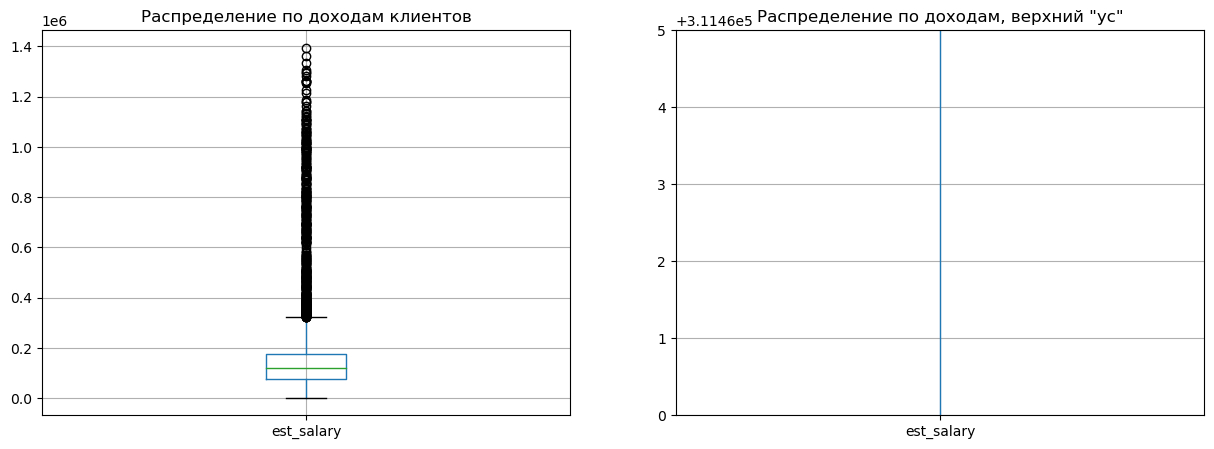

In [27]:
plt.figure(figsize=(15, 5))

ax1=plt.subplot(1, 2, 1)
df_eda.boxplot('est_salary')
plt.title('Распределение по доходам клиентов')

ax2=plt.subplot(1, 2, 2)
df_eda.boxplot('est_salary')
plt.ylim(311460, 311465)
plt.title('Распределение по доходам, верхний "ус"')

plt.show()

In [28]:
df_eda['est_salary'].describe()

count    9.966000e+03
mean     1.479725e+05
std      1.395536e+05
min      2.546300e+03
25%      7.526278e+04
50%      1.197315e+05
75%      1.745634e+05
max      1.395064e+06
Name: est_salary, dtype: float64

- Медианное значение дохода 116 923
- По графику видно, что за 311 464 начиннаются выбросы

### Проверим сколько данных мы в итоге потеряли

In [29]:
print(f'Мы потеряли: {"{0:.2f}".format((1 - df_eda.shape[0] / df.shape[0]) * 100)} % данных')

Мы потеряли: 0.33 % данных


Передед дальнейше работай сохраним копию датасета после обработки

In [30]:
df_check = df_eda.copy()

### Напишем функцию для создания категорий по баллам кредитного скоринга


- менее 770 -  Плохой
- 770 - 890 -  Средний
- 890 - 950 -  Хороший
- 950 - 1000 - Очень хороший

In [31]:
def data_score(row):
    if row < 770:
        return 'Плохой'
    if 770 <= row < 890:
        return 'Средний'
    if 890 <= row < 950:
        return 'Хороший'
    if row >= 950:
        return 'Очень хороший'

df_eda['score_level'] = df_eda['score'].apply(data_score)

### Напишем функцию для создания категорий по возрасту

- 18 - 22 -  Молодой возраст
- 22 - 30 -  Зрелый возраст
- 30 - 45 -  Средний возраст
- 45 - 65 -  Пожилой возраст
- более 65 - Пенсионный возраст

In [32]:
def data_age(row):
    if row <= 22:
        return 'Молодой'
    if 22 < row <= 30:
        return 'Зрелый'
    if 30 < row <= 45:
        return 'Средний'
    if 45 < row <=65:
        return 'Пожилой'
    if row > 65:
        return 'Пенсионный'

df_eda['age_level'] = df_eda['age'].apply(data_age)

### Напишем функцию для создания категорий по балансу на счёте

- менее 200 000 -  Низкий
- 200 000 - 800 000 -  Средний
- 800 000 - 1 500 000 -  Высокий
- более 1 500 000 -  Очень высокий

In [33]:
def data_balance(row):
    if row <= 200000:
        return 'Низкий'
    if 200000 < row <= 800000:
        return 'Средний'
    if 800000 < row <= 1500000:
        return 'Высокий'
    if row > 1500000:
        return 'Очень высокий'
    else:
        return 'Не определено'

df_eda['balance_level'] = df_eda['balance'].apply(data_balance)

### Напишем функцию для создания категорий по уровню дохода

- менее 13 000 -  Очень низкий, это прожиточный минимум для Ярославской области на 2022г.
- 13 000 - 45 000 -  Низкий
- 45 000 - 60 000 -  Средний
- 60 000 - 120 000 -  Выше среднего
- 120 000 - 250 000 - Высокий
- более 250 000 - Очень высокий

In [34]:
def data_salary(row):
    if row <= 13000:
        return 'Очень низкий'
    if 13000 < row <= 45000:
        return 'Низкий'
    if 45000 < row <= 60000:
        return 'Средний'
    if 60000 < row <= 120000:
        return 'Выше среднего'
    if 120000 < row <= 250000:
        return 'Высокий'
    if row > 250000:
        return 'Очень высокий'

df_eda['salary_level'] = df_eda['est_salary'].apply(data_salary)

### Переименуем данные в некоторых столбцах с 0 и 1 на удобный. Для построения графиков.

In [35]:
df_eda['gender']=df_eda['gender'].apply(lambda x: 'Мужской' if x=='М' else 'Женский')
df_eda['credit_card']=df_eda['credit_card'].apply(lambda x: 'Есть' if x==1 else 'Нет')
df_eda['last_activity']=df_eda['last_activity'].apply(lambda x: 'Активен' if x==1 else 'Не активен')
df_eda['churn']=df_eda['churn'].apply(lambda x: 'Ушёл' if x==1 else 'Остался')

### Выведем первые 10 строк обработанного датасета

In [36]:
df_eda.head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_level,age_level,balance_level,salary_level
0,183012,850.0,Рыбинск,Женский,25,1,59214.82,2,Нет,Активен,75719.14,Ушёл,Средний,Зрелый,Низкий,Выше среднего
1,146556,861.0,Рыбинск,Женский,37,5,850594.33,3,Есть,Не активен,86621.77,Остался,Средний,Средний,Высокий,Выше среднего
2,120722,892.0,Рыбинск,Женский,30,0,NaN,1,Есть,Активен,107683.34,Остался,Хороший,Зрелый,Не определено,Выше среднего
3,225363,866.0,Ярославль,Женский,51,5,1524746.26,2,Нет,Активен,174423.53,Ушёл,Средний,Пожилой,Очень высокий,Высокий
4,157978,730.0,Ярославль,Мужской,34,5,174.00,1,Есть,Не активен,67353.16,Ушёл,Плохой,Средний,Низкий,Выше среднего
5,202305,856.0,Рыбинск,Мужской,56,4,863687.24,3,Есть,Не активен,156619.80,Остался,Средний,Пожилой,Высокий,Высокий
6,177259,807.0,Ярославль,Женский,39,3,405042.44,3,Нет,Активен,103838.32,Остался,Средний,Средний,Средний,Выше среднего
7,218868,825.0,Ярославль,Женский,38,4,458145.40,2,Есть,Активен,68085.48,Остался,Средний,Средний,Средний,Выше среднего
8,211686,923.0,Ярославль,Мужской,54,5,1206337.87,2,Есть,Не активен,155371.79,Остался,Хороший,Пожилой,Высокий,Высокий
9,133130,906.0,Ярославль,Женский,67,0,NaN,1,Нет,Активен,238055.53,Остался,Хороший,Пенсионный,Не определено,Высокий


### Напишем функцию для построения пайчартов

In [37]:
def data(dt):
   
    plt.figure(figsize=(20, 20))
    
    dt1=dt['city'].value_counts().reset_index()
    
    ax1=plt.subplot(4,3,1)
    plt.title('Распределение по городам')
    ax1.pie(dt1['city'], labels=dt1['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    
    dt2=dt['gender'].value_counts().reset_index()
    ax2=plt.subplot(4,3,2)
    plt.title('Распределение по полу')
    ax2.pie(dt2['gender'], labels=dt2['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    dt3=dt['equity'].value_counts().reset_index()
    ax3=plt.subplot(4,3,3)
    plt.title('Распределение по оценке собственности')
    ax3.pie(dt3['equity'], labels=dt3['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    dt4=dt['products'].value_counts().reset_index()
    ax4=plt.subplot(4,3,4)
    plt.title('Распределение по количеству продуктов')
    ax4.pie(dt4['products'], labels=dt4['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    
    dt5=dt['credit_card'].value_counts().reset_index()
    ax5=plt.subplot(4,3,5)
    plt.title('Распределение по наличию кркдитной карты')
    ax5.pie(dt5['credit_card'], labels=dt5['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    
    dt6=dt['last_activity'].value_counts().reset_index()
    ax6=plt.subplot(4,3,6)
    plt.title('Распределение по последней активности')
    ax6.pie(dt6['last_activity'], labels=dt6['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    
    dt7=dt['churn'].value_counts().reset_index()
    ax7=plt.subplot(4,3,7)
    plt.title('Распределение по оттоку')
    ax7.pie(dt7['churn'], labels=dt7['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    
    dt8=dt['score_level'].value_counts().reset_index()
    ax8=plt.subplot(4,3,8)
    plt.title('Распределение по баллам кредитного скоринга')
    ax8.pie(dt8['score_level'], labels=dt8['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    dt9=dt['age_level'].value_counts().reset_index()
    ax9=plt.subplot(4,3,9)
    plt.title('Распределение по возрасту')
    ax9.pie(dt9['age_level'], labels=dt9['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    dt10=dt['balance_level'].value_counts().reset_index()
    ax10=plt.subplot(4,3,10)
    plt.title('Распределение по балансу')
    ax10.pie(dt10['balance_level'], labels=dt10['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    dt11=dt['salary_level'].value_counts().reset_index()
    ax11=plt.subplot(4,3,11)
    plt.title('Распределение по доходу')
    ax11.pie(dt11['salary_level'], labels=dt11['index'], autopct='%.2f%%', startangle=90, colors=['#2a5c9b','#3e769a','#50909c','#67a9a1','#82c1a9','#a4d8b6','#ceedc8','#ffffe0'])
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
   

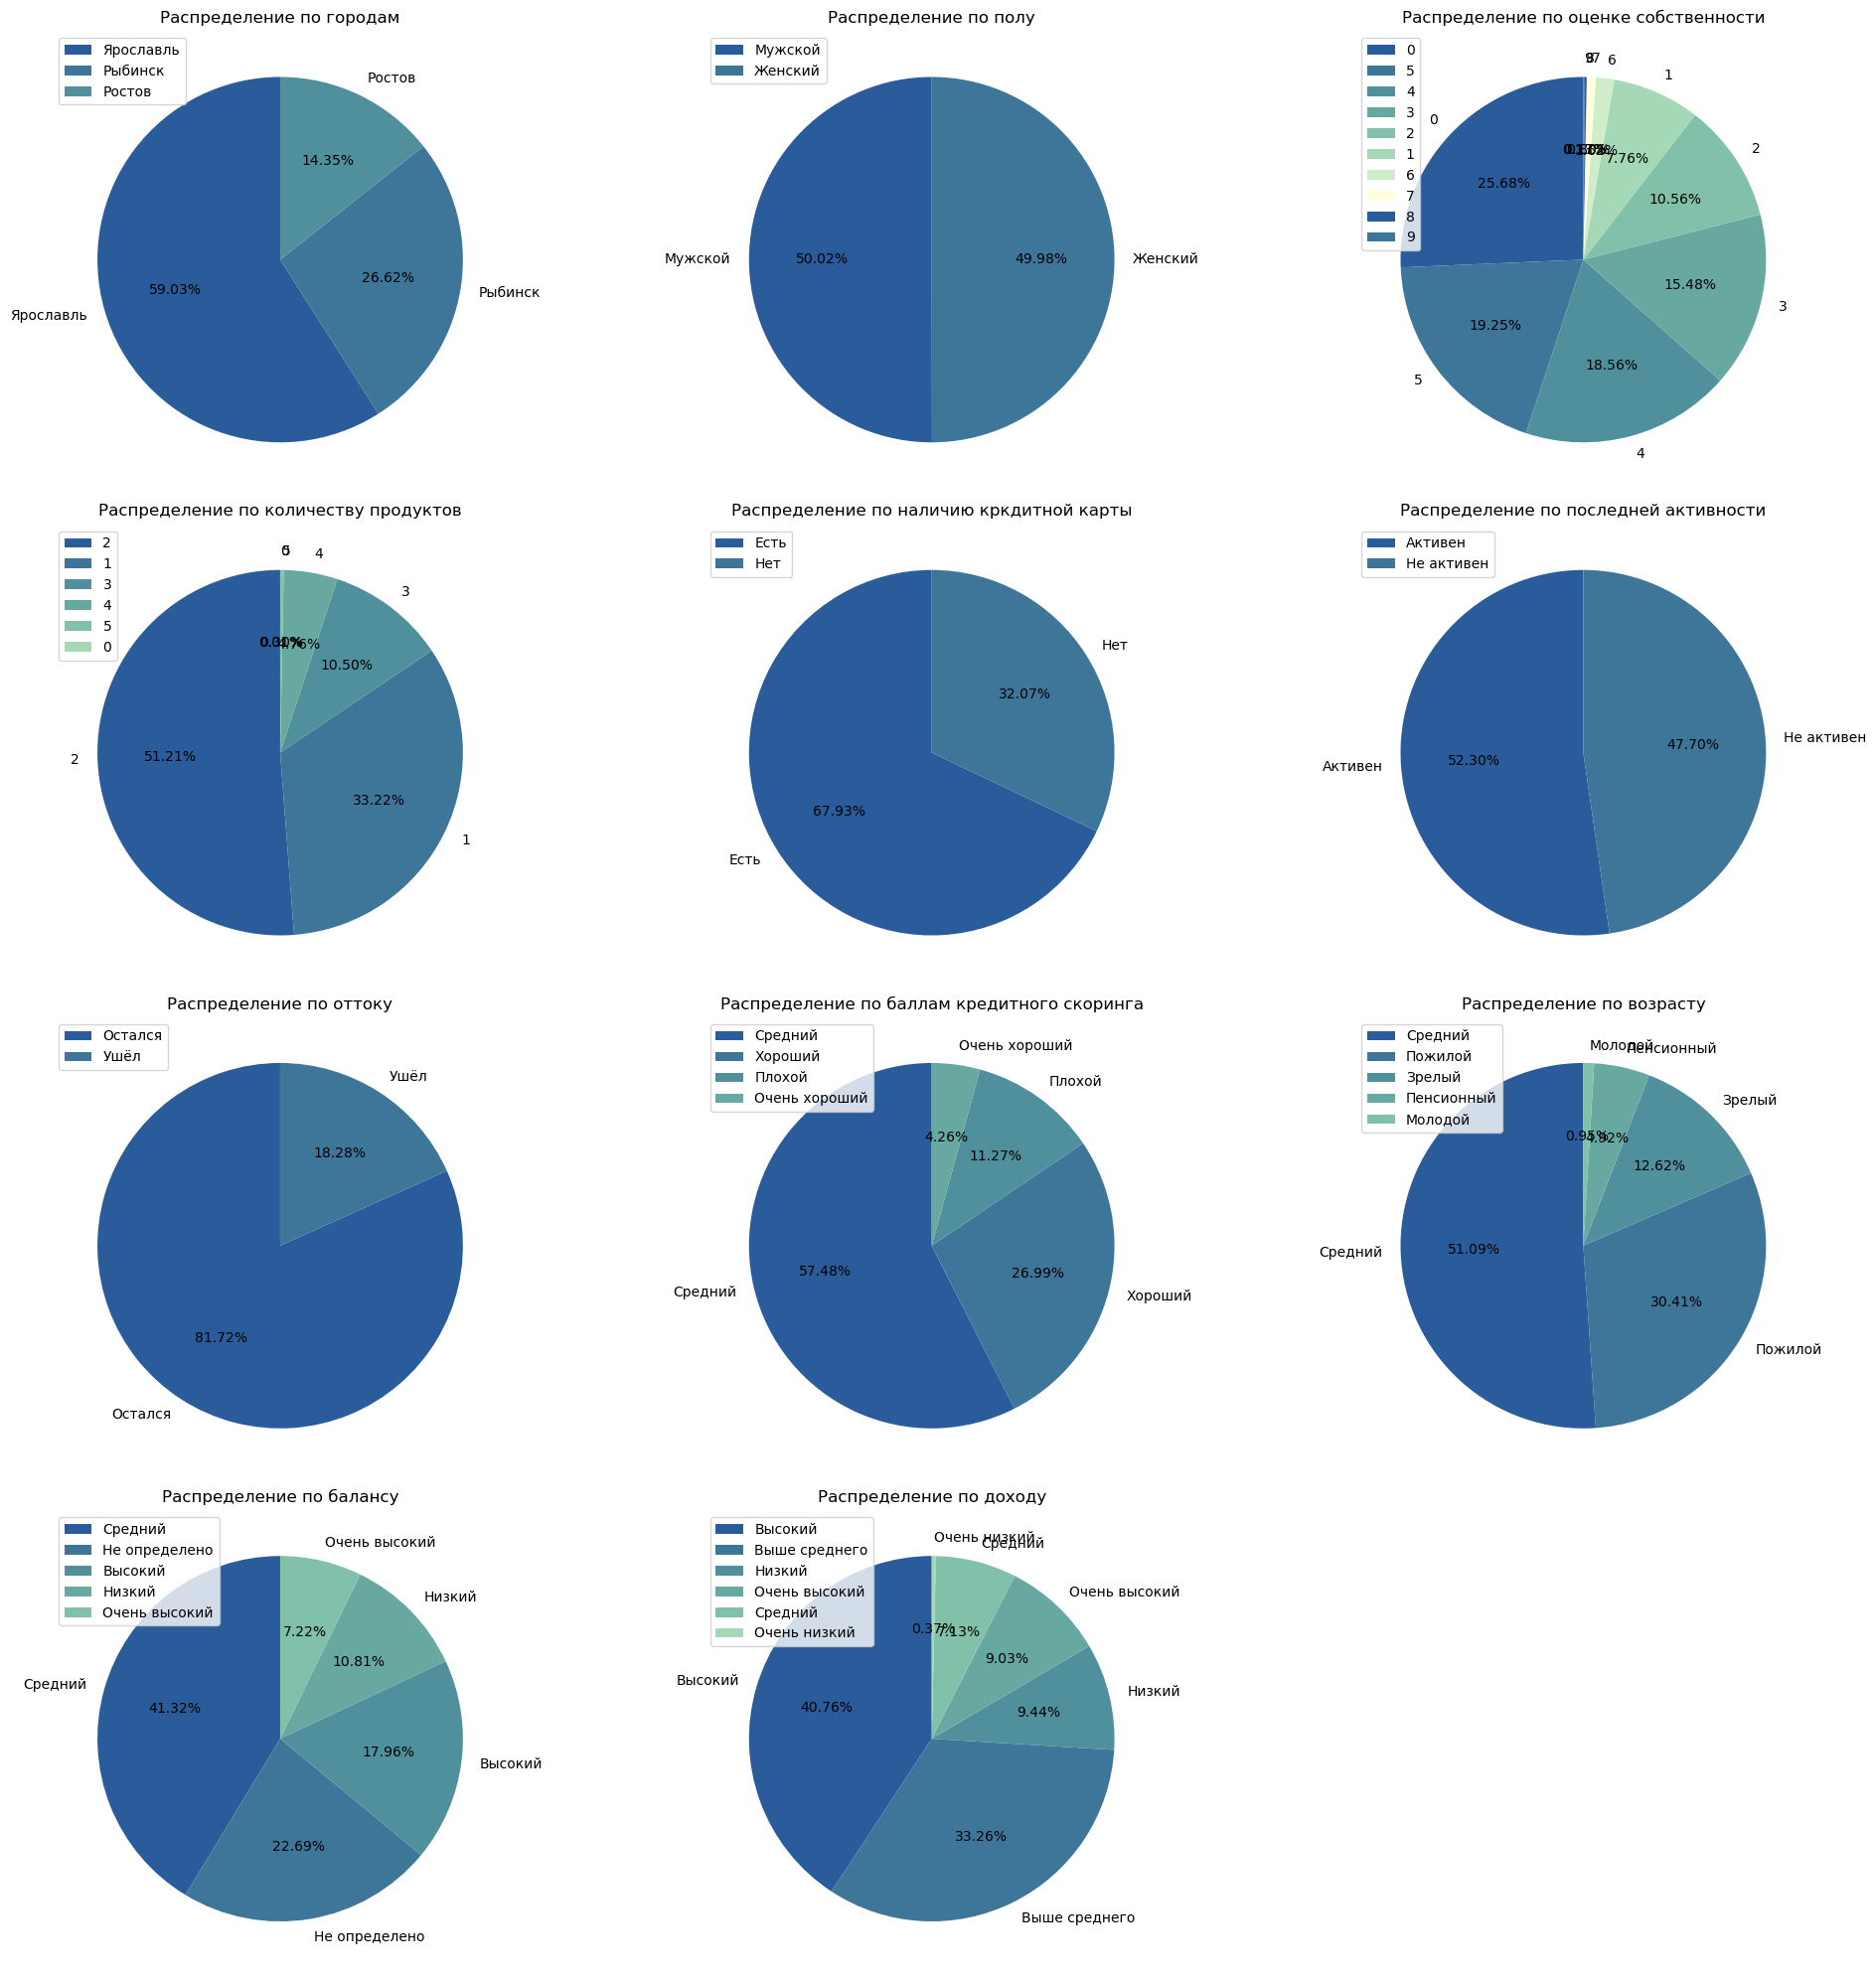

In [38]:
data(df_eda)

Вывод:

- Распределение клиентов по городам:
  - Ярославль - 59.09%
  - Рыбинск - 26.58%
  - Ростов - 14.33%
- Распределение клиентов по половому признаку - поровну
- Распределение клиентов по оценке собственности:
  - 0 - 25.69%
  - 5 - 19.29%
  - 4 - 18.59%
  - 3 - 15.42%
  - 2 - 10.56 %
- Распределение клиентов по количеству продуктов:
  - 2 - 51.26%
  - 1 - 33.20%
  - 3 - 10.46%
- Распределение клиентов по наличию кредитной карты:
  - Есть - 67.97%
  - Нет - 32.03%
- Распределение клиентов по последней активности:
  - Активен - 52.24%
  - Не активен - 47.76%
- Распределение клиентов по оттоку:
  - Остался - 81.65%
  - Ушёл - 18.35%
- Распределение клиентов по баллам кредитного скоринга:
  - Средний - 57.48%
  - Хороший - 27.00%
  - Плохой - 11.25%
- Распределение клиентов по возрасту:
  - Средний возраст - 51.30%
  - Пожилой возраст - 30.54%
  - Зрелый возраст - 12.68%
- Распределение клиентов по балансу:
  - Средний - 41.31%
  - Не определено - 22.68%
  - Высокий - 17.95%
- Распределение по доходу:
  - Высокий - 40.90%
  - Выше среднего - 33.25%
  - Низкий - 9.35%

### Посмотрим на распределение клиентов с пропущенными значениями в балансе

In [40]:
df_notbalance=df_eda[df_eda['balance'].isna()]

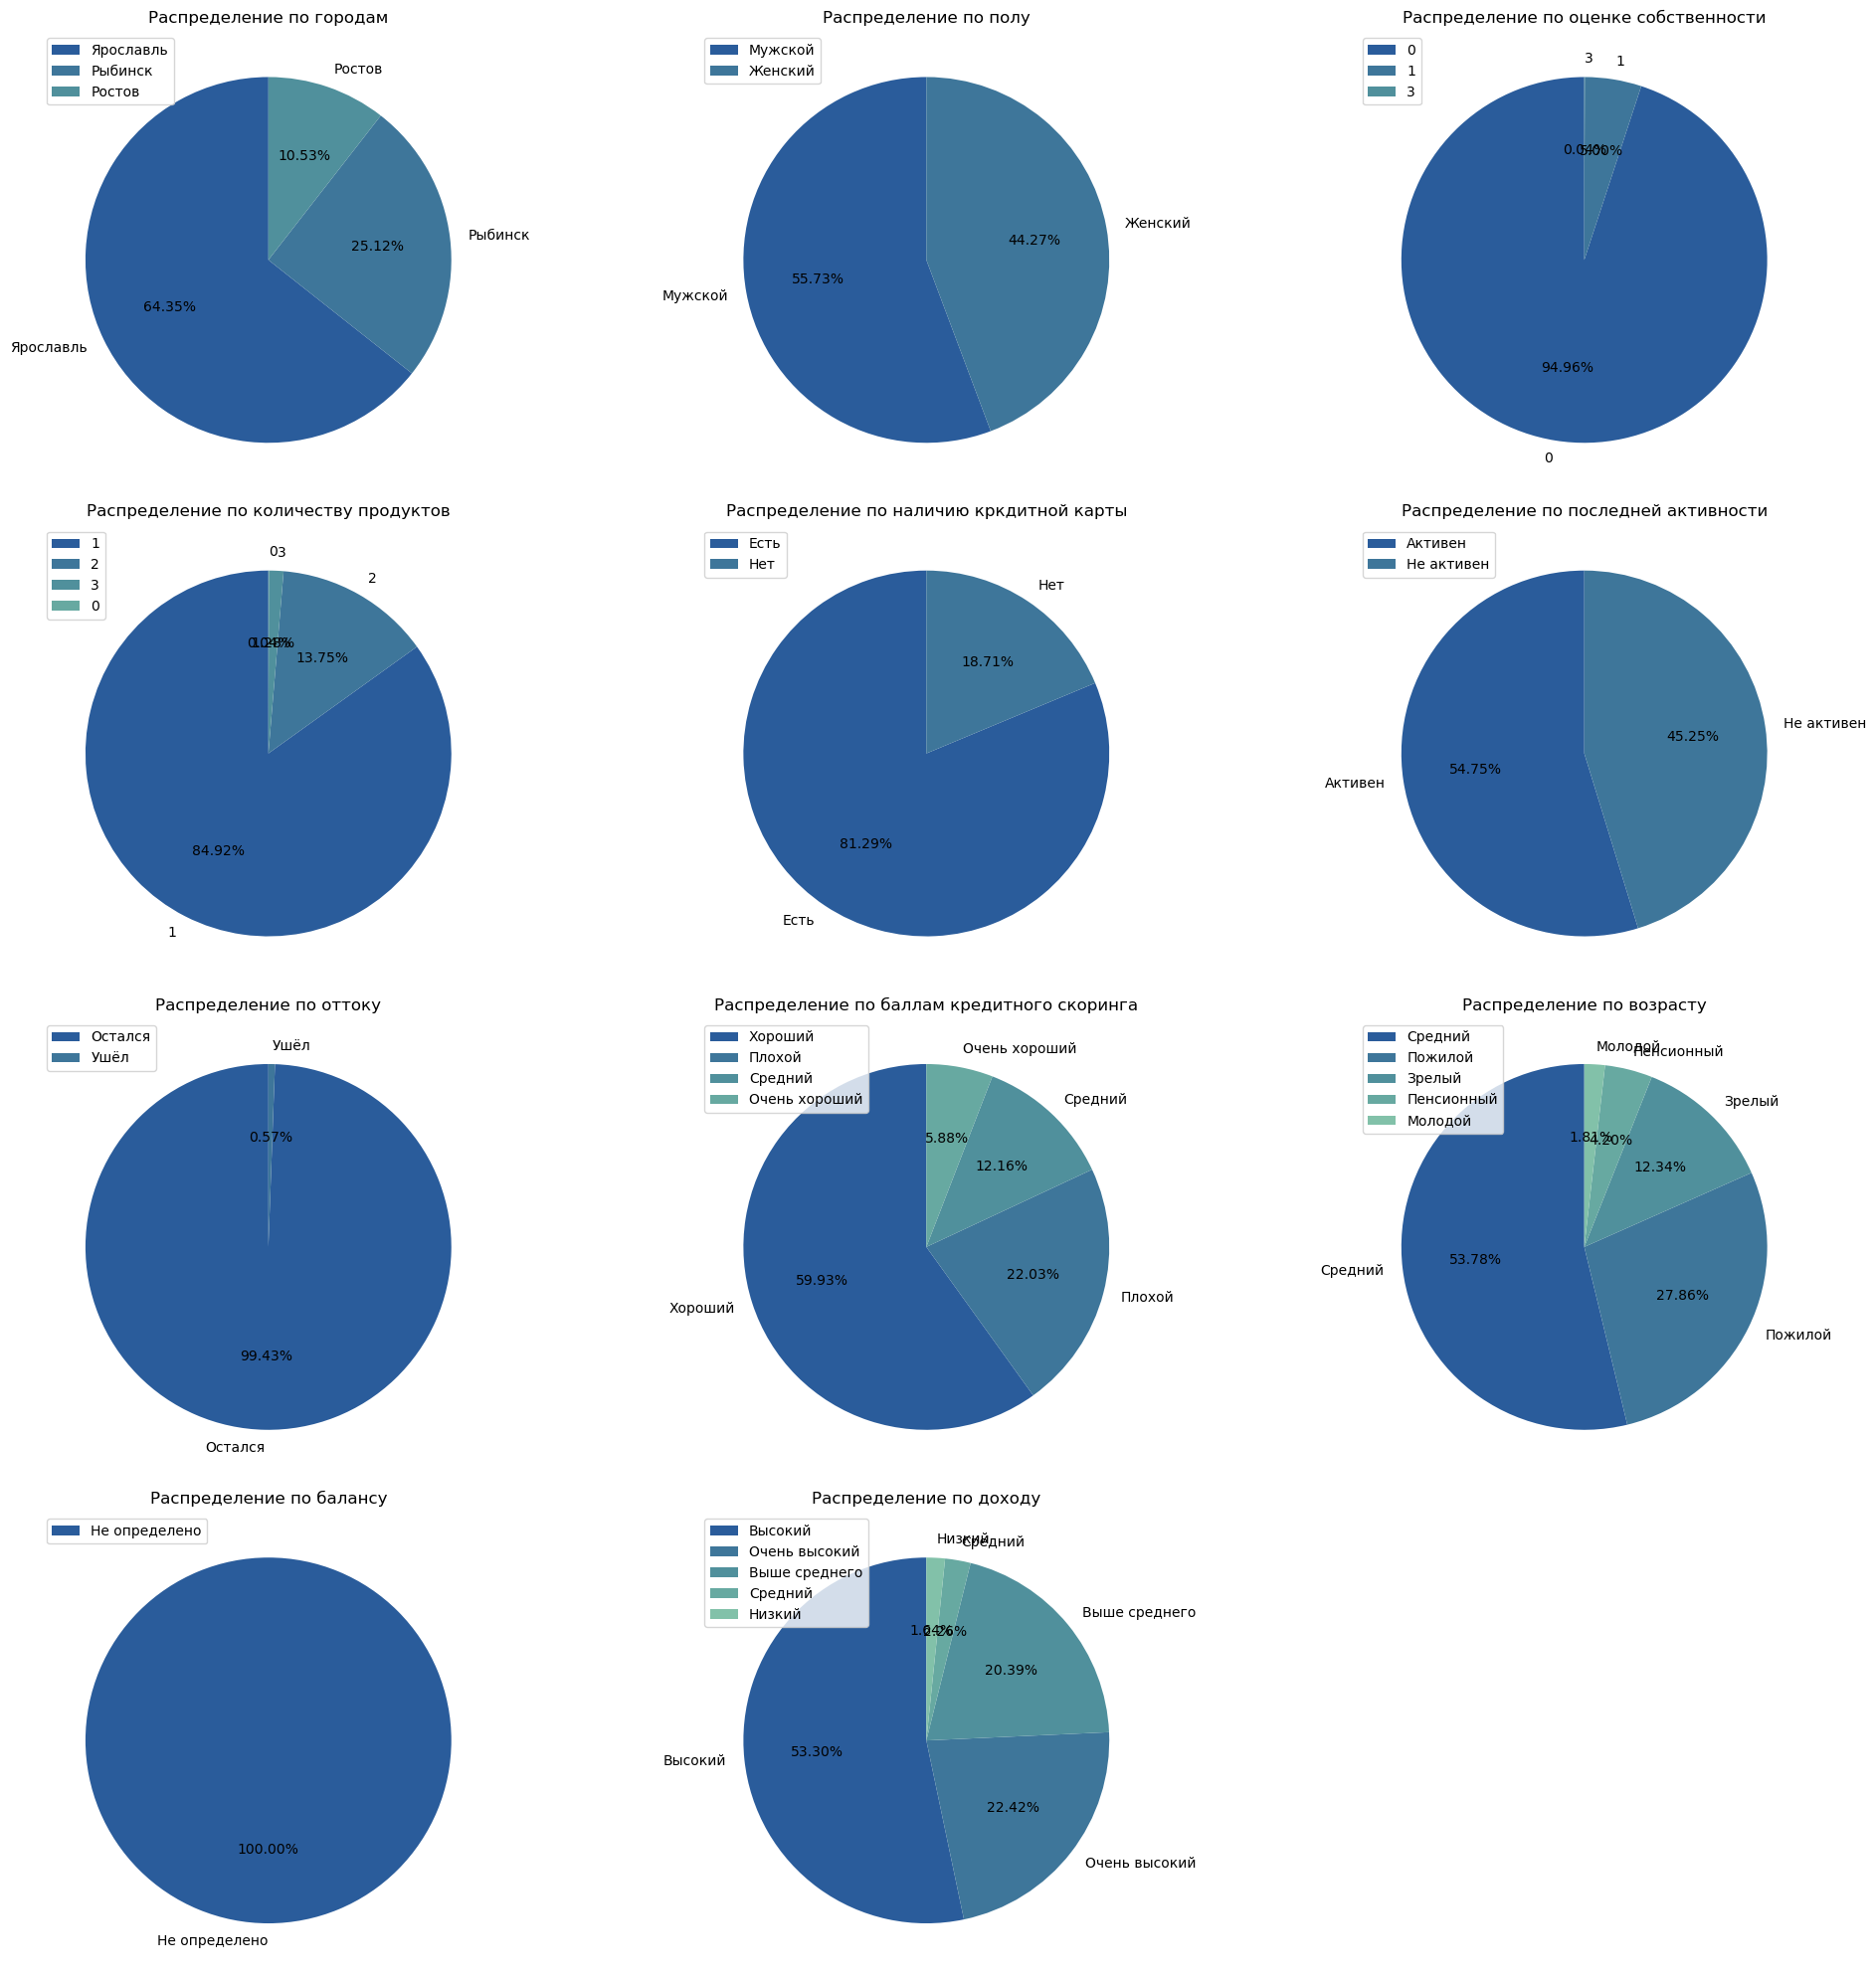

In [41]:
data(df_notbalance)

Портрет клиента, у которого отсутствуют данные в балансе:
- Нулевая оценка собственности 94.98%
- Пользователь одного банковского продукта 84.90%
- Есть кредитная карта 81.34%
- Остался в банке 99.47%

Новых идей о причинах пропуска не появилось.

### Посмотрим на распределение клиентов среди ушедших

In [42]:
df_churn=df_eda[df_eda['churn'] == 'Ушёл']

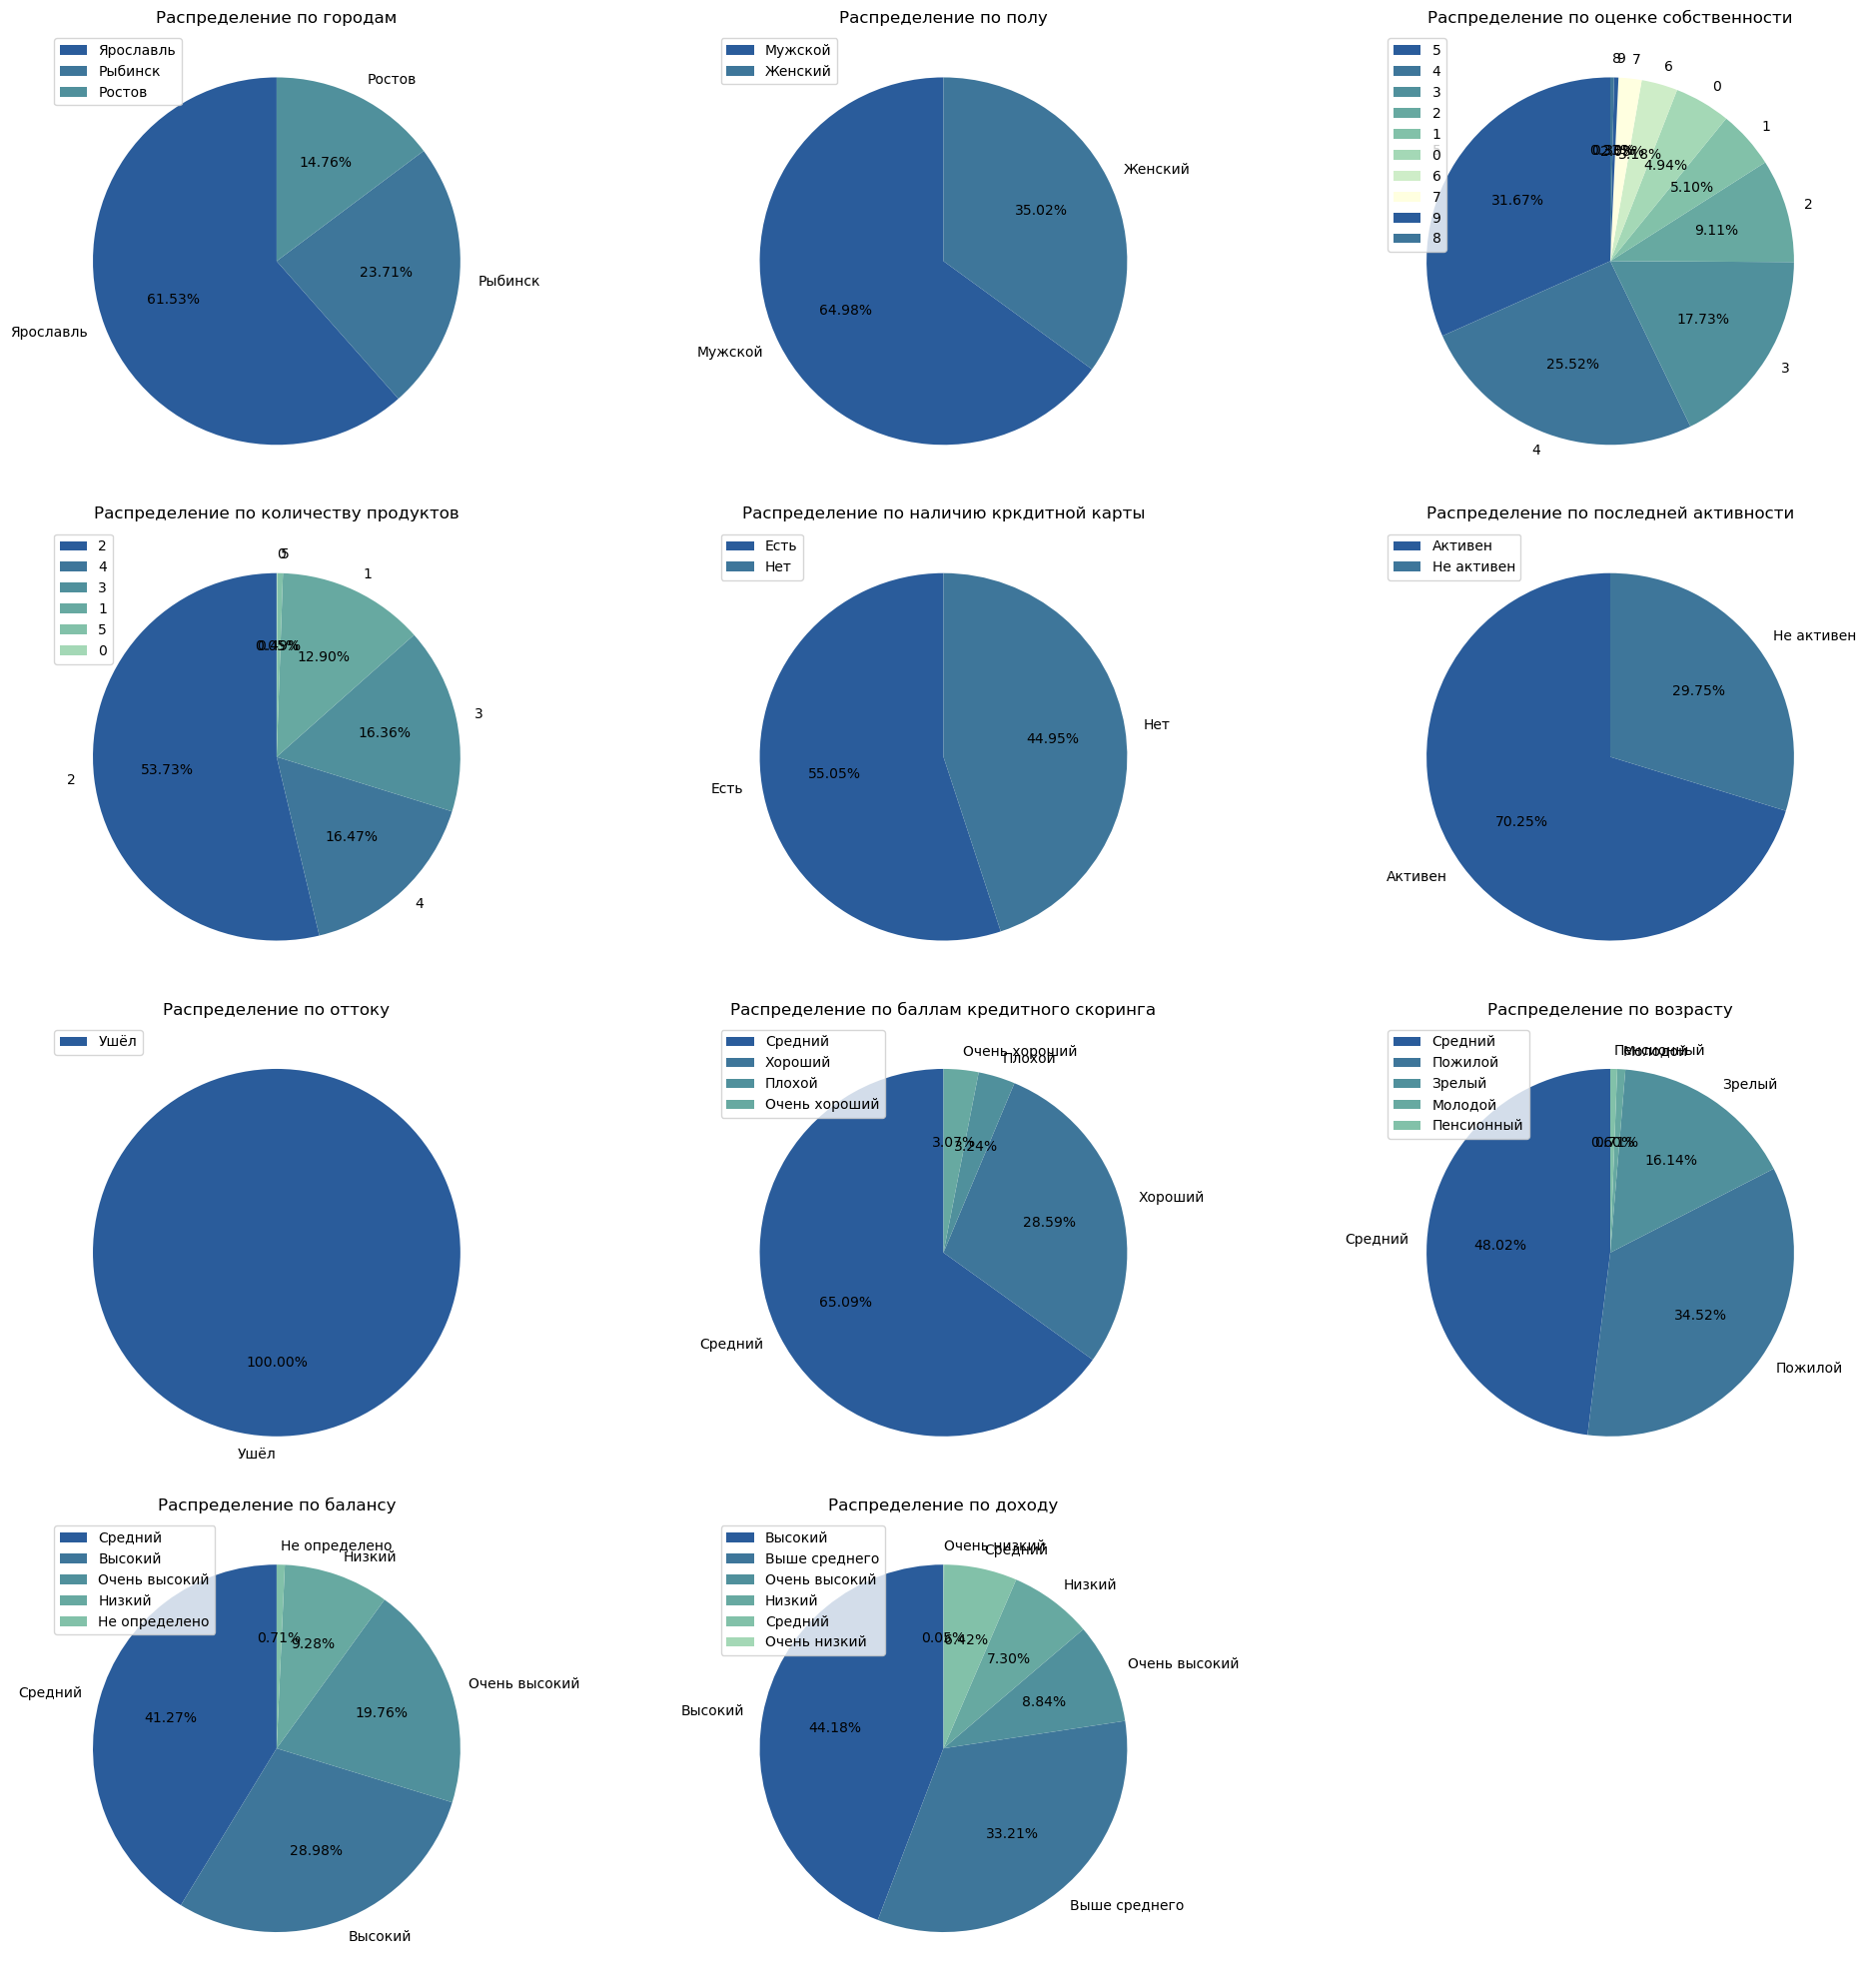

In [43]:
data(df_churn)

Портрет ушедшего клиента:

- Распределение по городам:
  - Ярославль - 61.56%
  - Рыбинск - 24.35%
  - Ростов - 14.77%
- Распределение по половому признаку:
  - Мужской - 65.02%
  - Женский - 34.98%
- Распределение по оценке собственности:
  - 5 - 31.69%
  - 4 - 25.54%
  - 3 - 17.68%
  - 2 - 9.12 %
- Распределение по количеству продуктов:
  - 2 - 53.76%
  - 4 - 16.47%
  - 3 - 16.36%
- Распределение по наличию кредитной карты:
  - Есть - 55.08%
  - Нет - 44.92%
- Распределение по последней активности:
  - Активен - 70.29%
  - Не активен - 29.71%
- Распределение по баллам кредитного скоринга:
  - Средний - 65.13%
  - Хороший - 28.61%
  - Плохой - 3.24%
- Распределение по возрасту:
  - Средний возраст - 48.05%
  - Пожилой возраст - 34.54%
  - Зрелый возраст - 16.14%
- Распределение по балансу:
  - Средний - 41.30%
  - Высокий- 29.00%
  - Низкий - 19.77%
- Распределение по доходу:
  - Высокий - 44.21%
  - Выше среднего - 33.22%
  - Очень высокий - 8.84%

### Напишем функцию для построения гистограмм в разбивке на "остался" или "ушёл" клиент

In [44]:
def data_histplot(dt):
    plt.figure(figsize=(30,25))
   
    ax1=plt.subplot(5,3,1)
    sns.histplot(data=dt, hue='churn', x='score_level', stat='density', common_norm=False)
    ax1.set_title('Распределение по баллам кредитного скоринга', fontsize=15)
    ax1.set(xlabel='', ylabel='Количество клиентов')
    
    ax2=plt.subplot(5,3,2)
    sns.histplot(data=dt, hue='churn', x='city', stat='density', common_norm=False)
    ax2.set_title('Распределение по городам', fontsize=15)
    ax2.set(xlabel='', ylabel='Количество клиентов')

    ax3=plt.subplot(5,3,3)
    sns.histplot(data=dt, hue='churn', x='gender', stat='density', common_norm=False)
    ax3.set_title('Распределение по половому признаку', fontsize=15)
    ax3.set(xlabel='', ylabel='Количество клиентов')

    ax4=plt.subplot(5,3,4)
    sns.histplot(data=dt, hue='churn', x='age_level', stat='density', common_norm=False)
    ax4.set_title('Распределение по возрасту', fontsize=15)
    ax4.set(xlabel='', ylabel='Количество клиентов')

    ax5=plt.subplot(5,3,5)
    sns.histplot(data=dt, hue='churn', x='equity', bins=10, stat='density', common_norm=False)
    ax5.set_title('Распределение по оценке собственности', fontsize=15)
    ax5.set(xlabel='', ylabel='Количество клиентов')

    ax6=plt.subplot(5,3,6)
    sns.histplot(data=dt, hue='churn', x='balance_level', stat='density', common_norm=False)
    ax6.set_title('Распределение по балансу на счёте', fontsize=15)
    ax6.set(xlabel='', ylabel='Количество клиентов')


    ax7=plt.subplot(5,3,7)
    sns.histplot(data=dt, hue='churn', x='products', bins=5, stat='density', common_norm=False)
    ax7.set_title('Распределение по количеству банковских продуктов', fontsize=15)
    ax7.set(xlabel='', ylabel='Количество клиентов')


    ax8=plt.subplot(5,3,8)
    sns.histplot(data=dt, hue='churn', x='credit_card', stat='density', common_norm=False)
    ax8.set_title('Распределение по наличию кредитной карты', fontsize=15)
    ax8.set(xlabel='', ylabel='Количество клиентов')


    ax9=plt.subplot(5,3,9)
    sns.histplot(data=dt, hue='churn', x='last_activity', stat='density', common_norm=False)
    ax9.set_title('Распределение по активности', fontsize=15)
    ax9.set(xlabel='', ylabel='Количество клиентов')

    ax10=plt.subplot(5,3,10)
    sns.histplot(data=dt, hue='churn', x='salary_level', stat='density', common_norm=False)
    ax10.set_title('Распределение по уровню дохода', fontsize=15)
    ax10.set(xlabel='', ylabel='Количество клиентов')

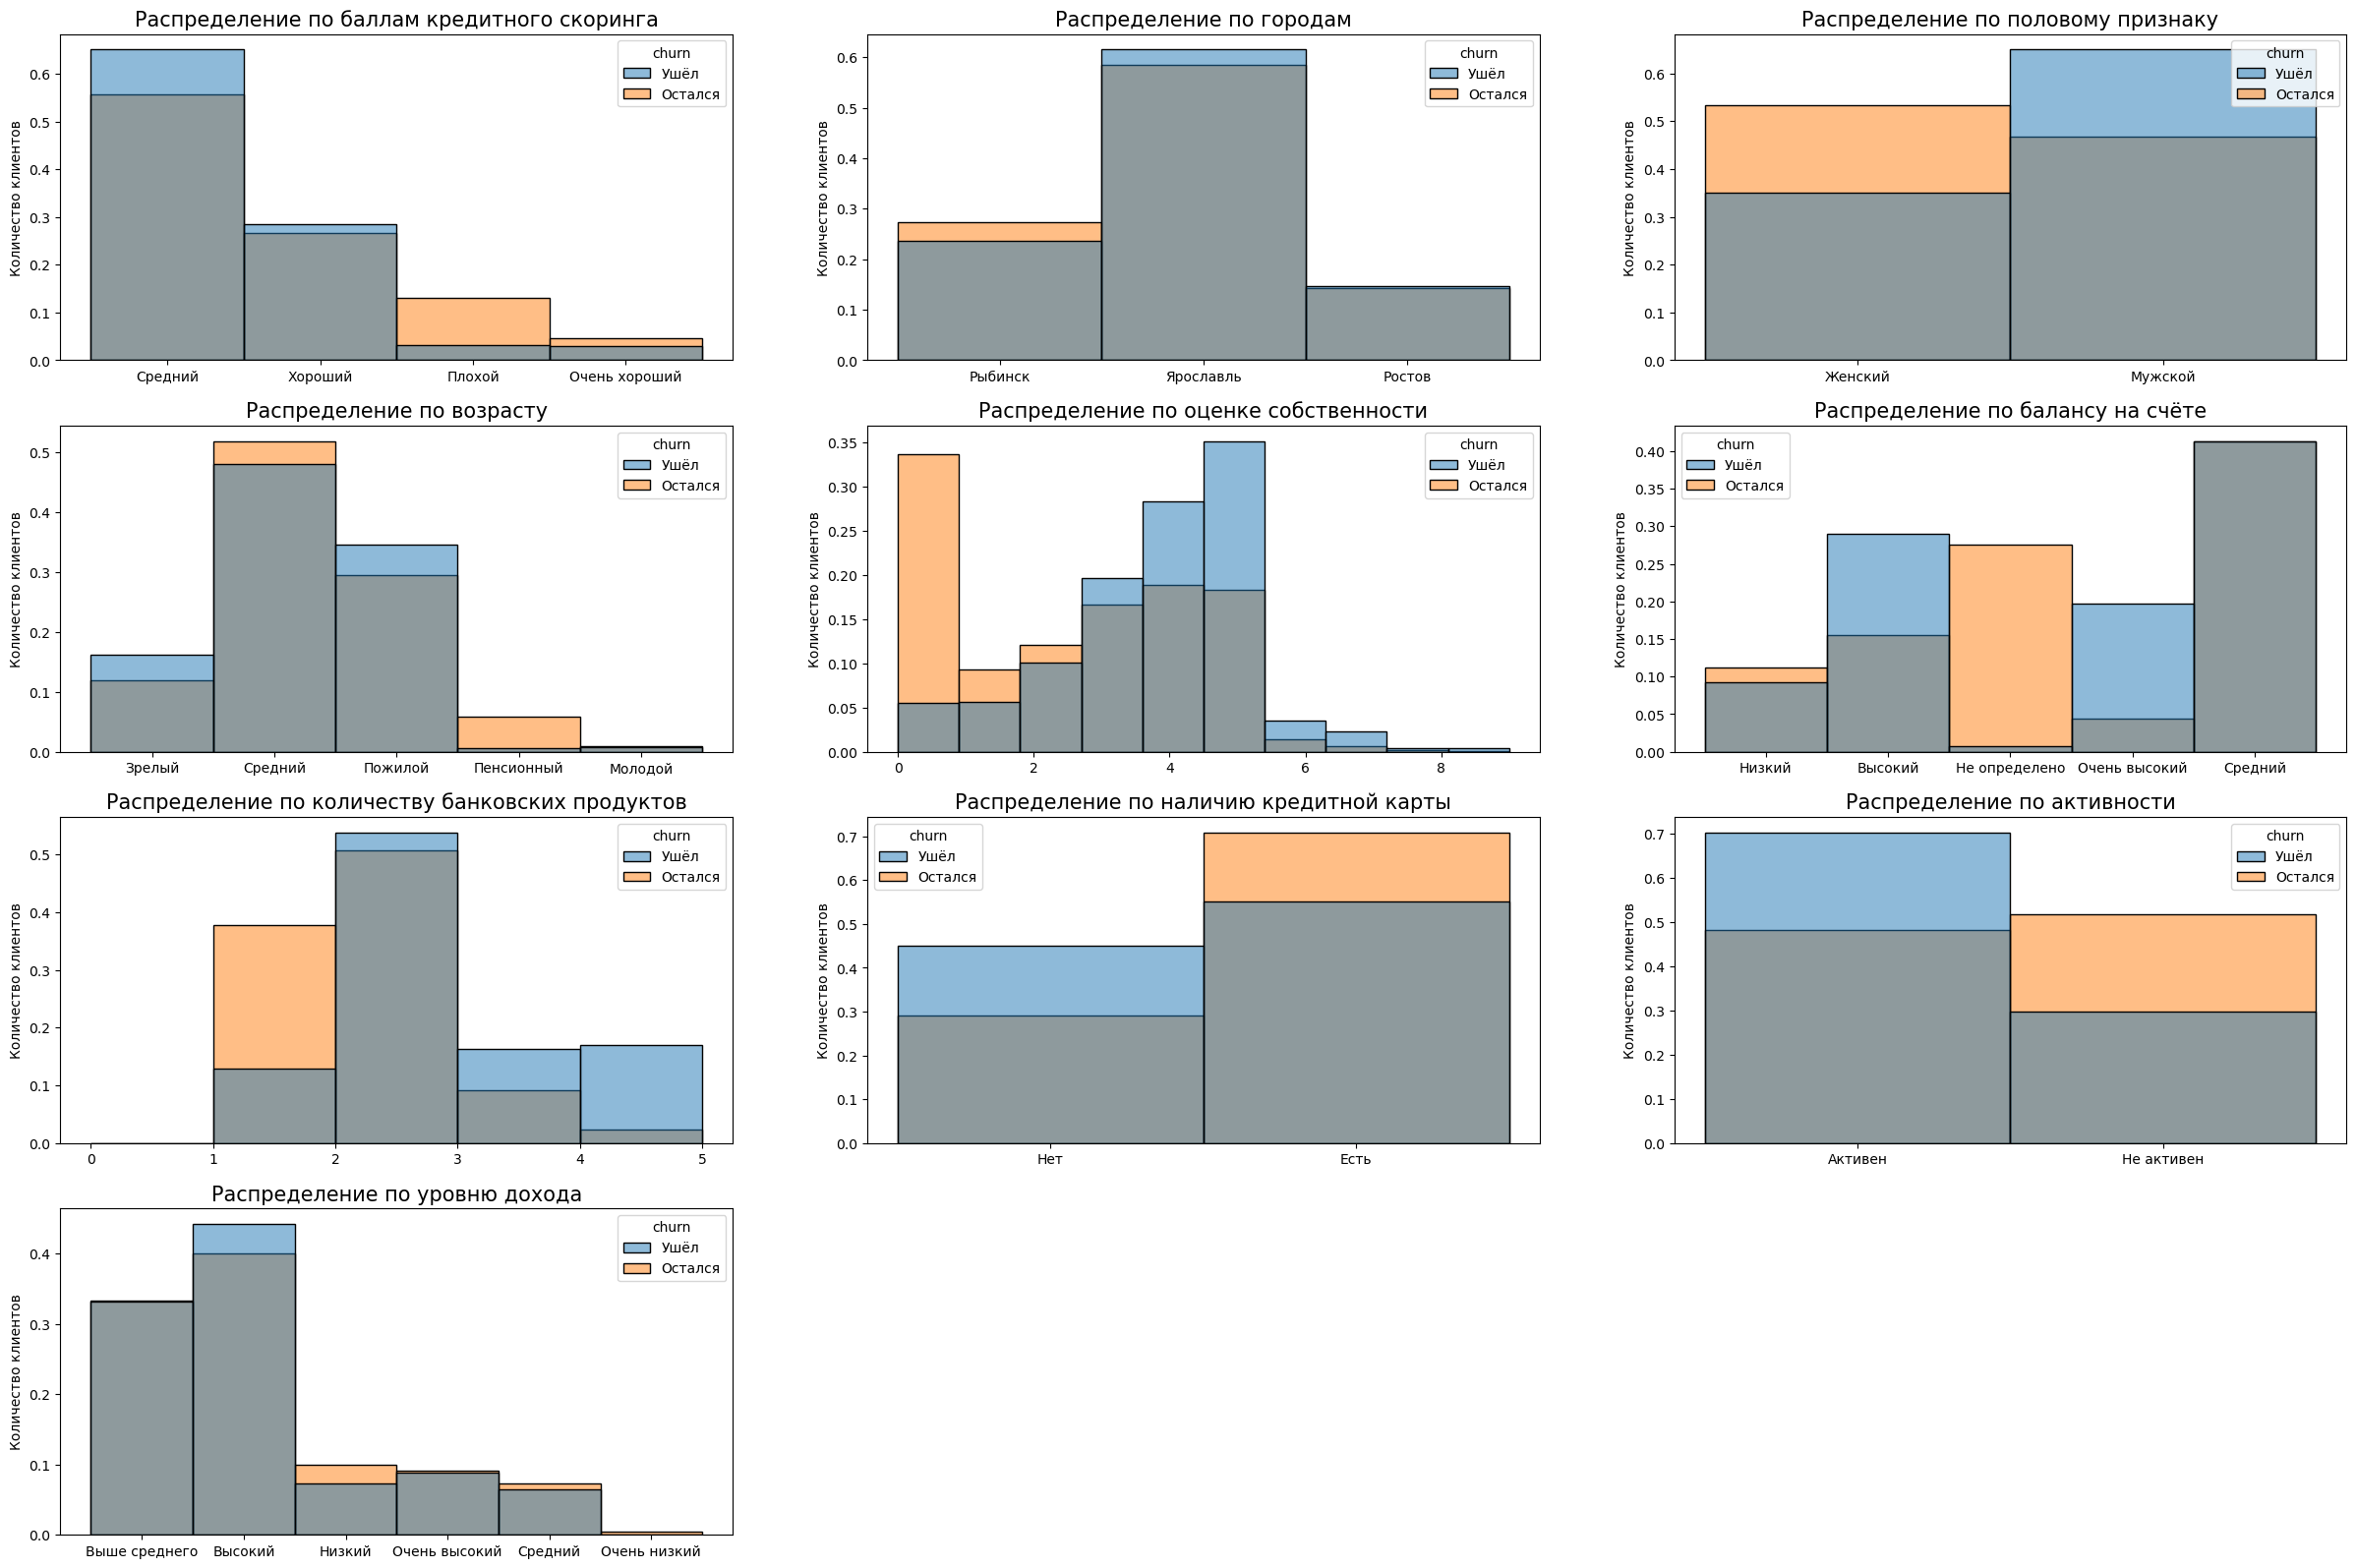

In [45]:
data_histplot(df_eda)

**Зафиксируем категории в которых доля оттока выше всего:**
- Оценка собственности = 6, 7, 8, 9
- Баланс = Очень высокий
- Банковские продукты = 4, 5

**Также зафиксируем где доля оттока незначительно превышает долю оставшихся:**
- Баллы кредитного скоринга = Средний
- Город = Ярославль
- Пол = Мужской
- Возраст = Зрелый, Пожилой
- Оценка собственности = 3, 4, 5
- Баланс = Высокий, Средний
- Банковские продукты = 2, 3
- Наличие кредитной карты = Нет
- Активность = Активен
- Доход = Высокий

### Проверим различные зависимости, корреляции

**Преобразуем столбцы из категориальных значений в числовые, при этом я понимаю, что это не корректно, тем не менее посмотри, что из этого получится**

In [46]:
df_check['Рыбинск']=df_check['city'].apply(lambda x: 1 if x=='Рыбинск' else 0)
df_check['Ярославль']=df_check['city'].apply(lambda x: 1 if x=='Ярославль' else 0)
df_check['Ростов']=df_check['city'].apply(lambda x: 1 if x=='Ростов' else 0)
df_check['gender']=df_check['gender'].apply(lambda x: 1 if x=='М' else 0)

In [47]:
df_check = df_check.drop('city', axis=1)
df_check.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Рыбинск,Ярославль,Ростов
0,183012,850.0,0,25,1,59214.82,2,0,1,75719.14,1,1,0,0
1,146556,861.0,0,37,5,850594.33,3,1,0,86621.77,0,1,0,0
2,120722,892.0,0,30,0,NaN,1,1,1,107683.34,0,1,0,0
3,225363,866.0,0,51,5,1524746.26,2,0,1,174423.53,1,0,1,0
4,157978,730.0,1,34,5,174.00,1,1,0,67353.16,1,0,1,0


**Построим тепловую карту используя метод Спирмена**

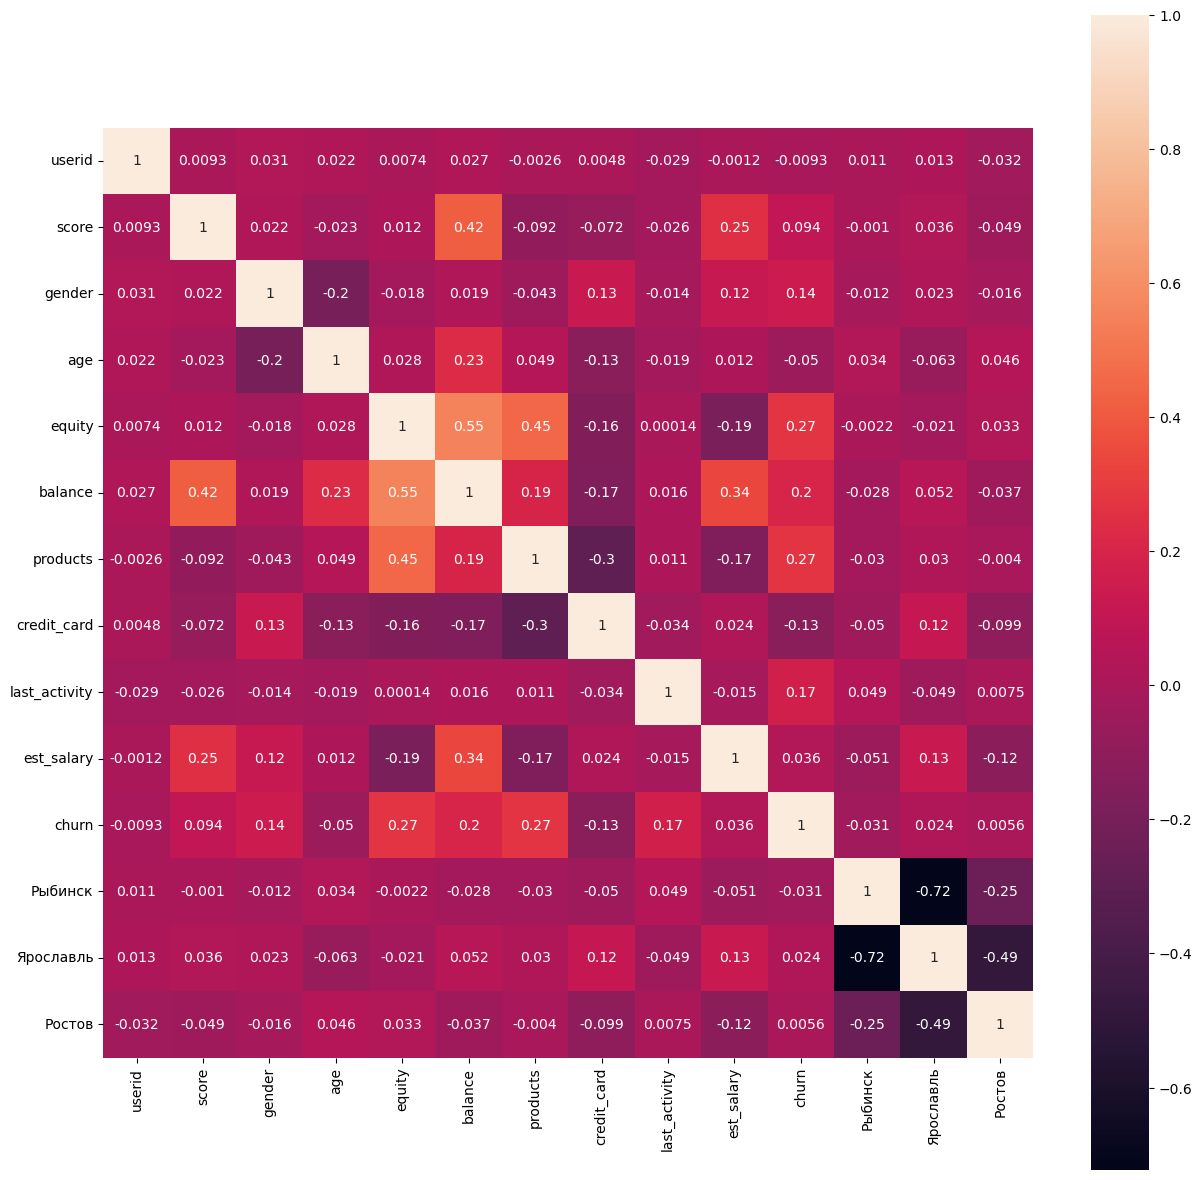

In [48]:
plt.figure(figsize=(15,15))
sns.heatmap(df_check.corr(method='spearman'), annot=True, square=True)
plt.show()

**Вывод: По шкале Чеддока корреляцая слабая, есть умеренные зависимотси. В целом зависимости не наблюдаются.**

## Проверим гипотезы

### Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались

Сформируем гипотезы:
- Н0: Средний доход клиентов, которые остались(0) = Средний доход клиентов, которые ушли(1)
- Н1: Средний доход клиентов, которые остались(0) ≠ Средний доход клиентов, которые ушли(1)

In [49]:
results = st.ttest_ind(
    df.loc[df.churn == 0, 'est_salary'],
    df.loc[df.churn == 1, 'est_salary'],
    )

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.9039093696714597
Не получилось отвергнуть нулевую гипотезу 


**Значимых различий между средними доходами нет**

### Гипотеза различия баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались (возможно будет редактироваться!)

Сформируем гипотезы:
- Н0: Средний балл кредитного скоринга клиентов, которые остались(0) = Средний балл кредитного скоринга клиентов, которые ушли(1)
- Н1: Средний балл кредитного скоринга клиентов, которые остались(0) ≠ Средний балл кредитного скоринга клиентов, которые ушли(1)

In [50]:
results = st.ttest_ind(
    df.loc[df.churn == 0, 'products'],
    df.loc[df.churn == 1, 'products'],
    )

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

7.12614975972525e-203
Отвергаем нулевую гипотезу 


**Есть значимые различия между средними баллами кредитного скоринга у тех, кто ушел и тех, кто остался**

## Сегментация клиентов

### Сегмент 1: Клиенты из г. Ярославль с средним уровнем баллов кредитного скоринга

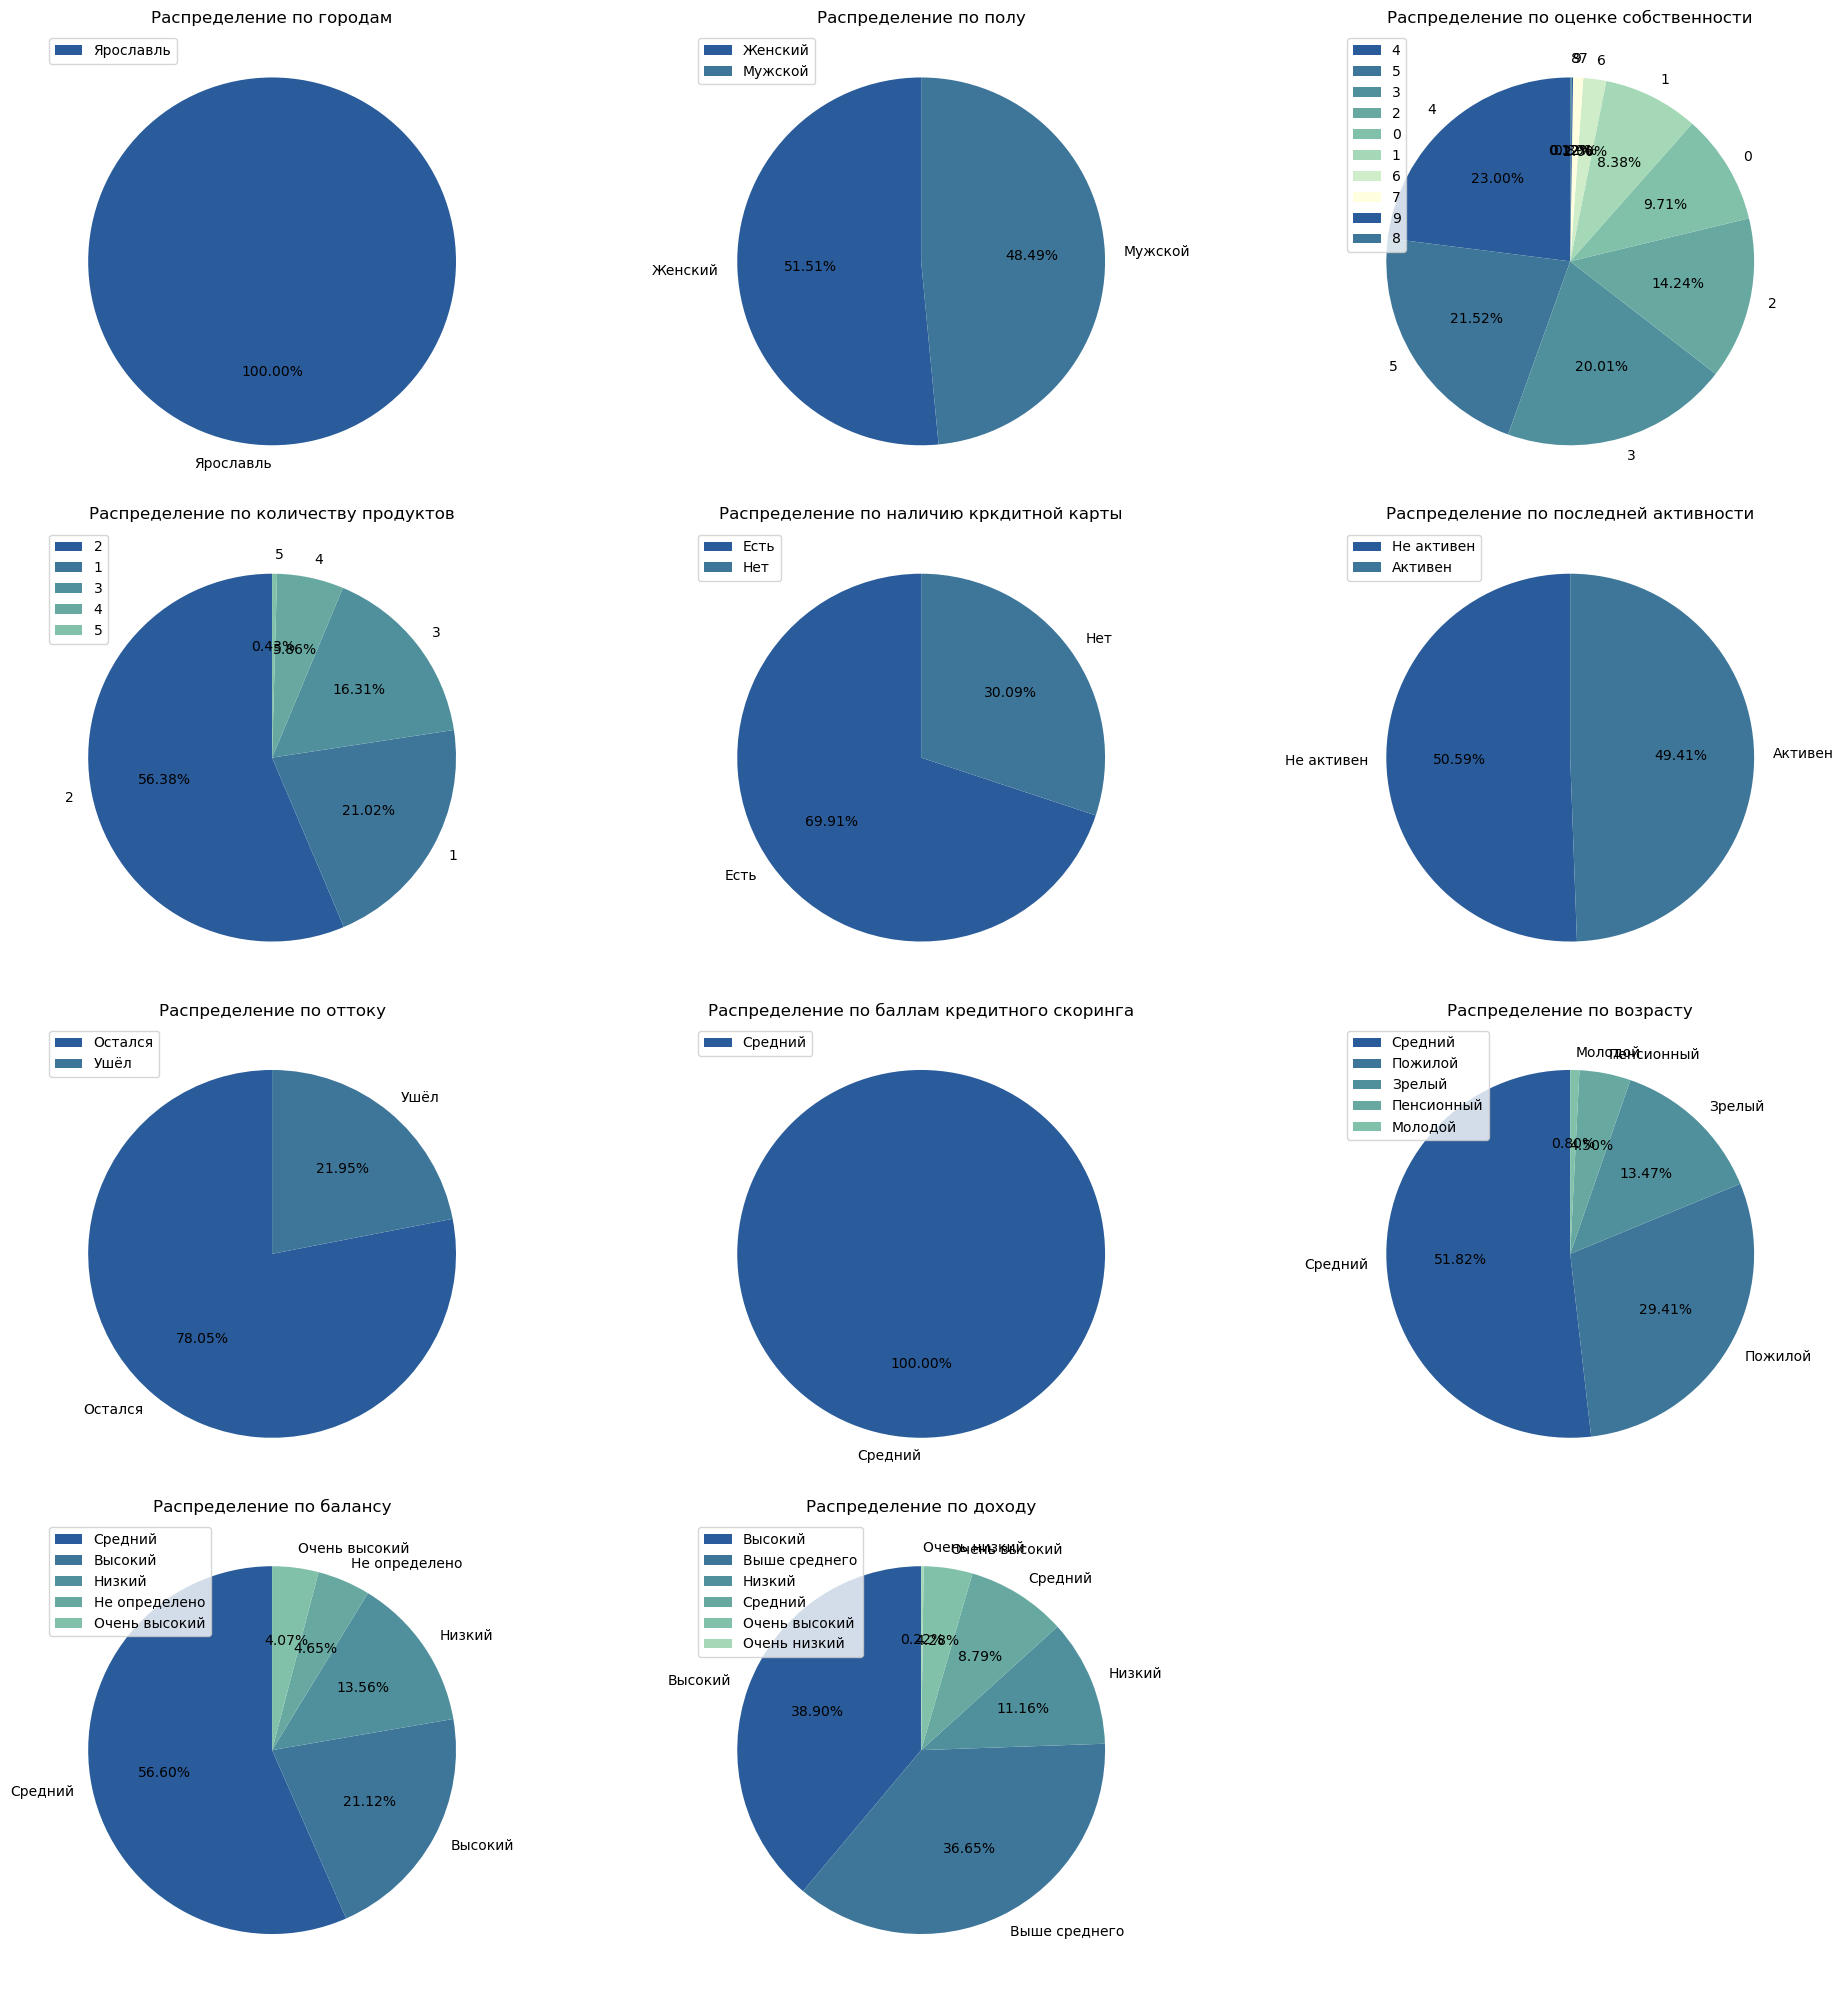

In [51]:
df_1 = df_eda.query('(city == "Ярославль") and (score_level == "Средний")')
data(df_1)

In [52]:
print(
    f'Из данного сегмента ушли {df_1[df_1["churn"] == "Ушёл"]["userid"].nunique()} клиент.',
    f'Это составляет {"{0:.2f}".format(df_1[df_1["churn"] == "Ушёл"]["userid"].nunique() / df_eda[df_eda["churn"] == "Ушёл"]["userid"].nunique()*100)}% от общего числа ушедших.'
)

Из данного сегмента ушли 712 клиент. Это составляет 39.10% от общего числа ушедших.


### Сегмент 2: Клиенты мужского пола с средним уровнем баллов кредитного скоринга

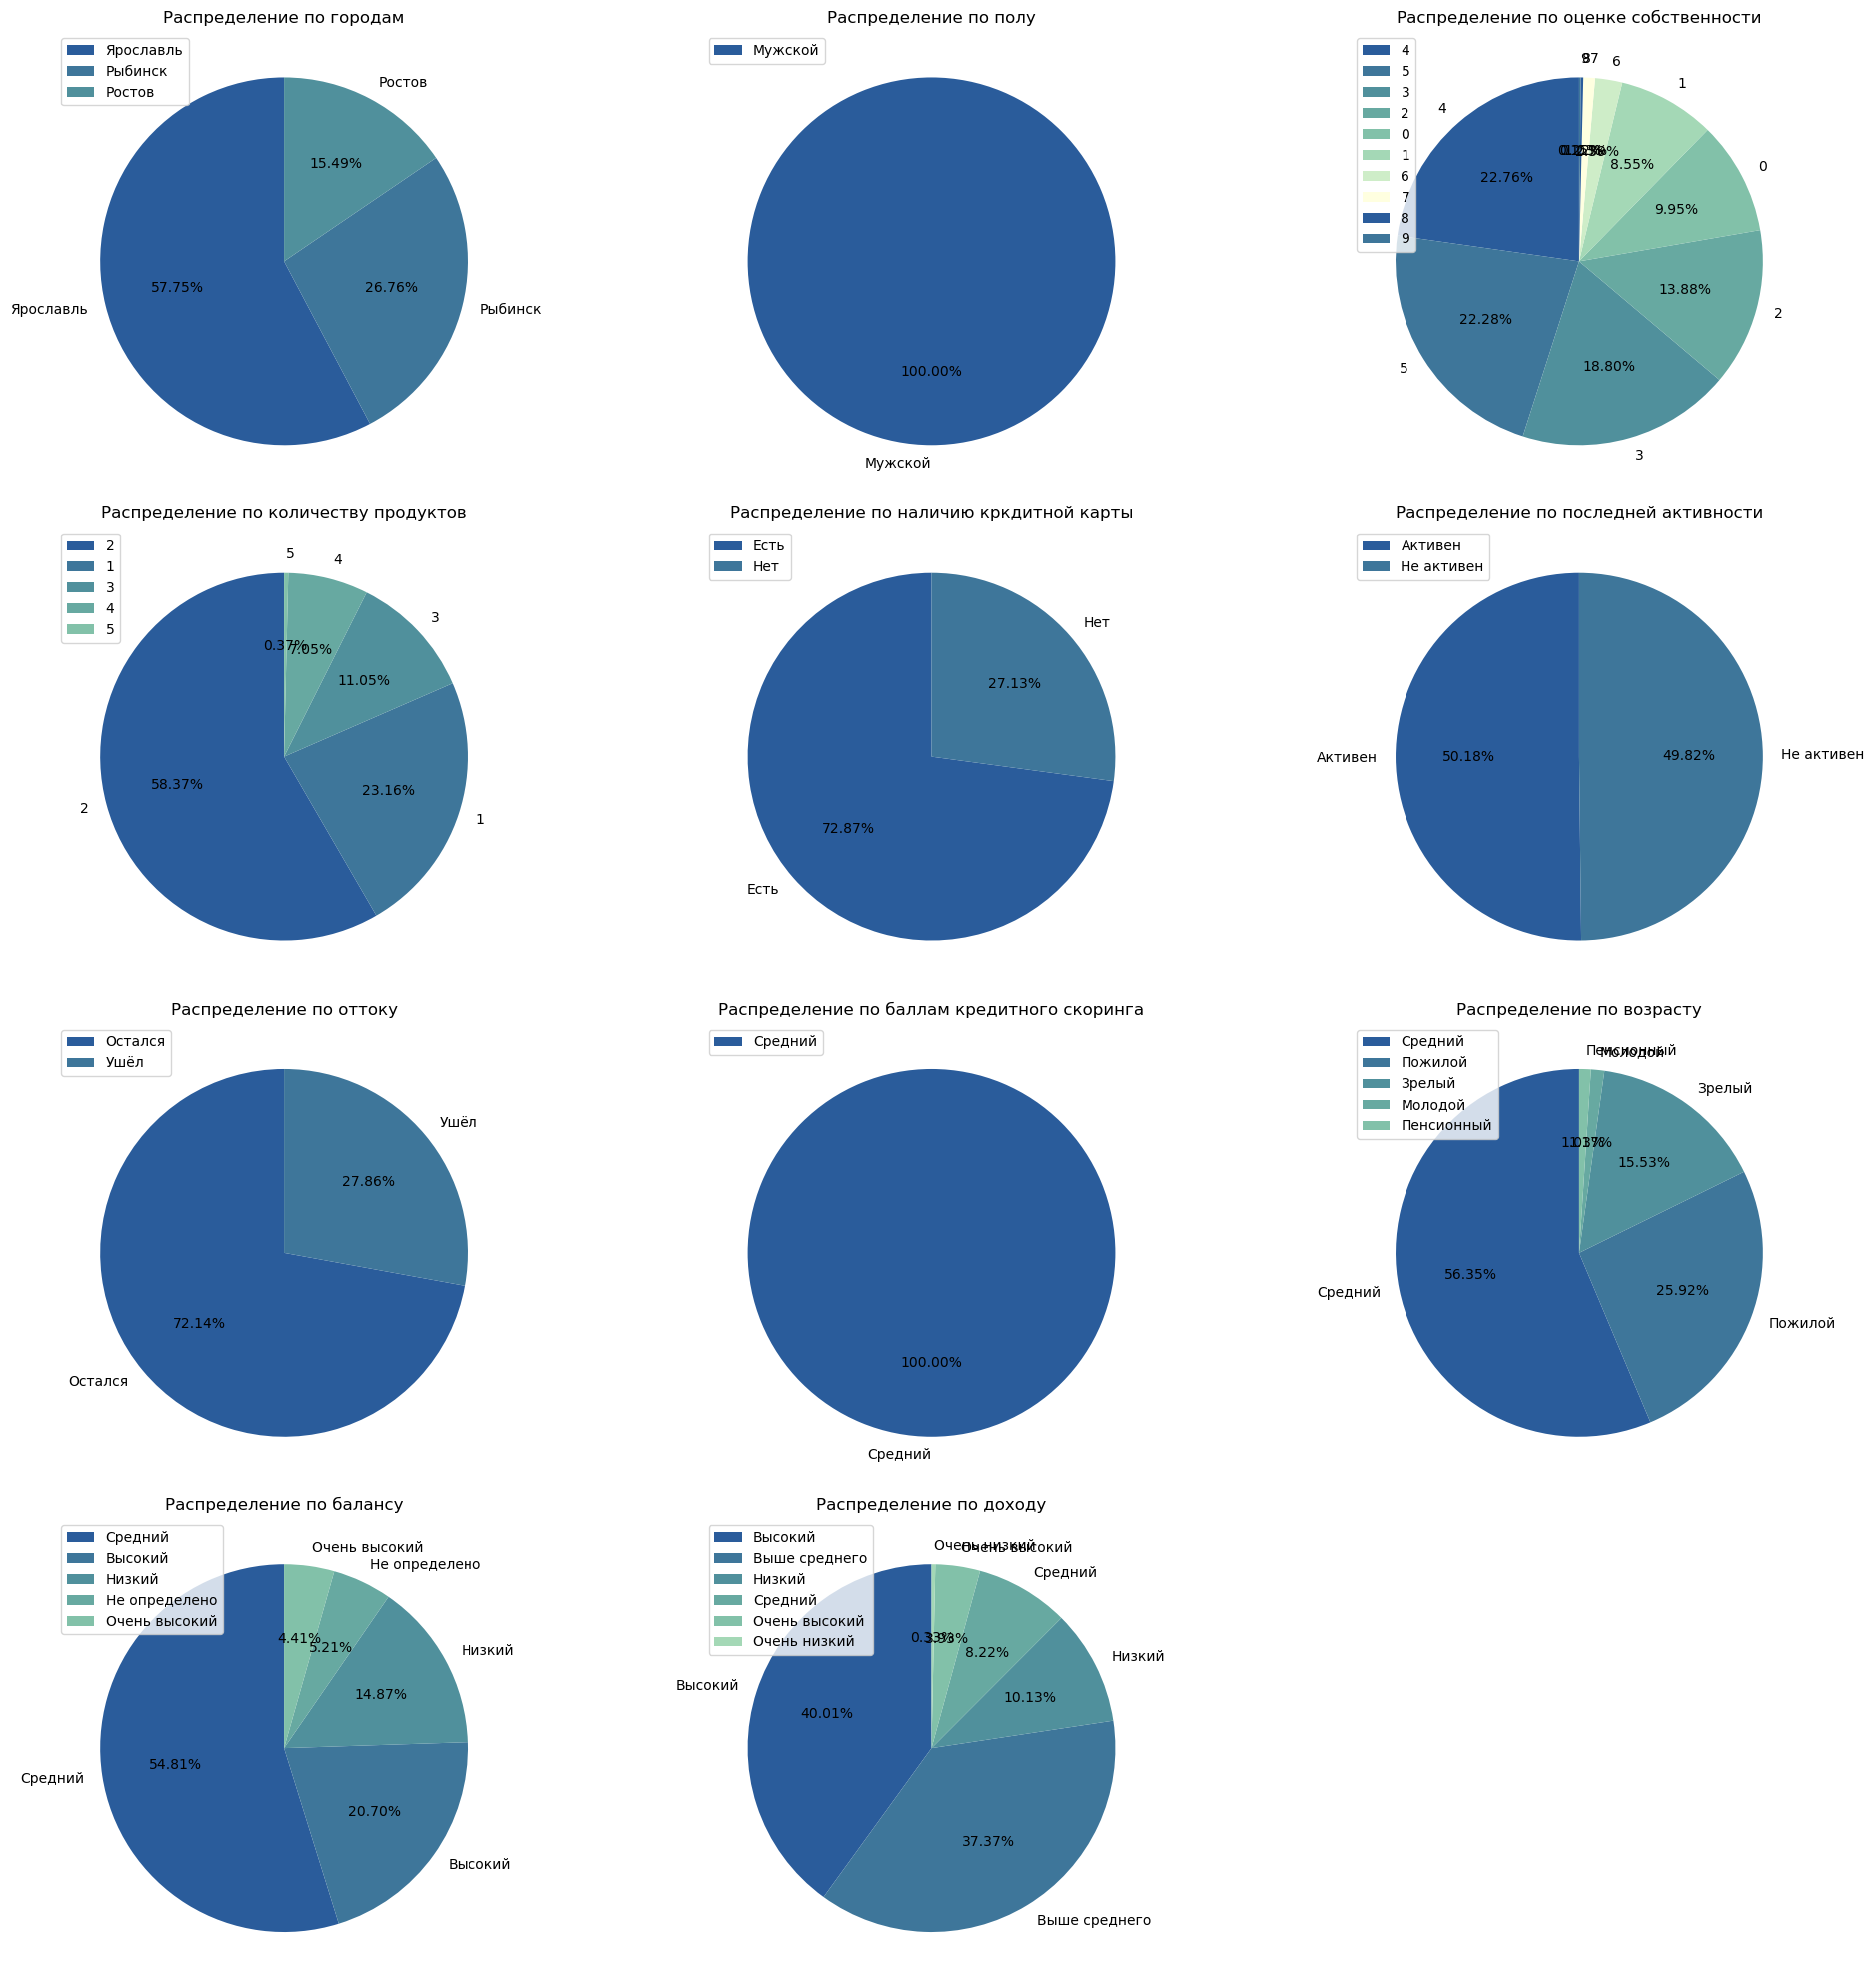

In [53]:
df_2 = df_eda.query('(gender == "Мужской") and (score_level == "Средний")')
data(df_2)

In [54]:
print(
    f'Из данного сегмента ушли {df_2[df_2["churn"] == "Ушёл"]["userid"].nunique()} клиента.',
    f'Это составляет {"{0:.2f}".format(df_2[df_2["churn"] == "Ушёл"]["userid"].nunique() / df_eda[df_eda["churn"] == "Ушёл"]["userid"].nunique()*100)}% от общего числа ушедших.'
)

Из данного сегмента ушли 759 клиента. Это составляет 41.68% от общего числа ушедших.


### Сегмент 3: Активные клиенты с средним уровнем баллов кредитного скоринга

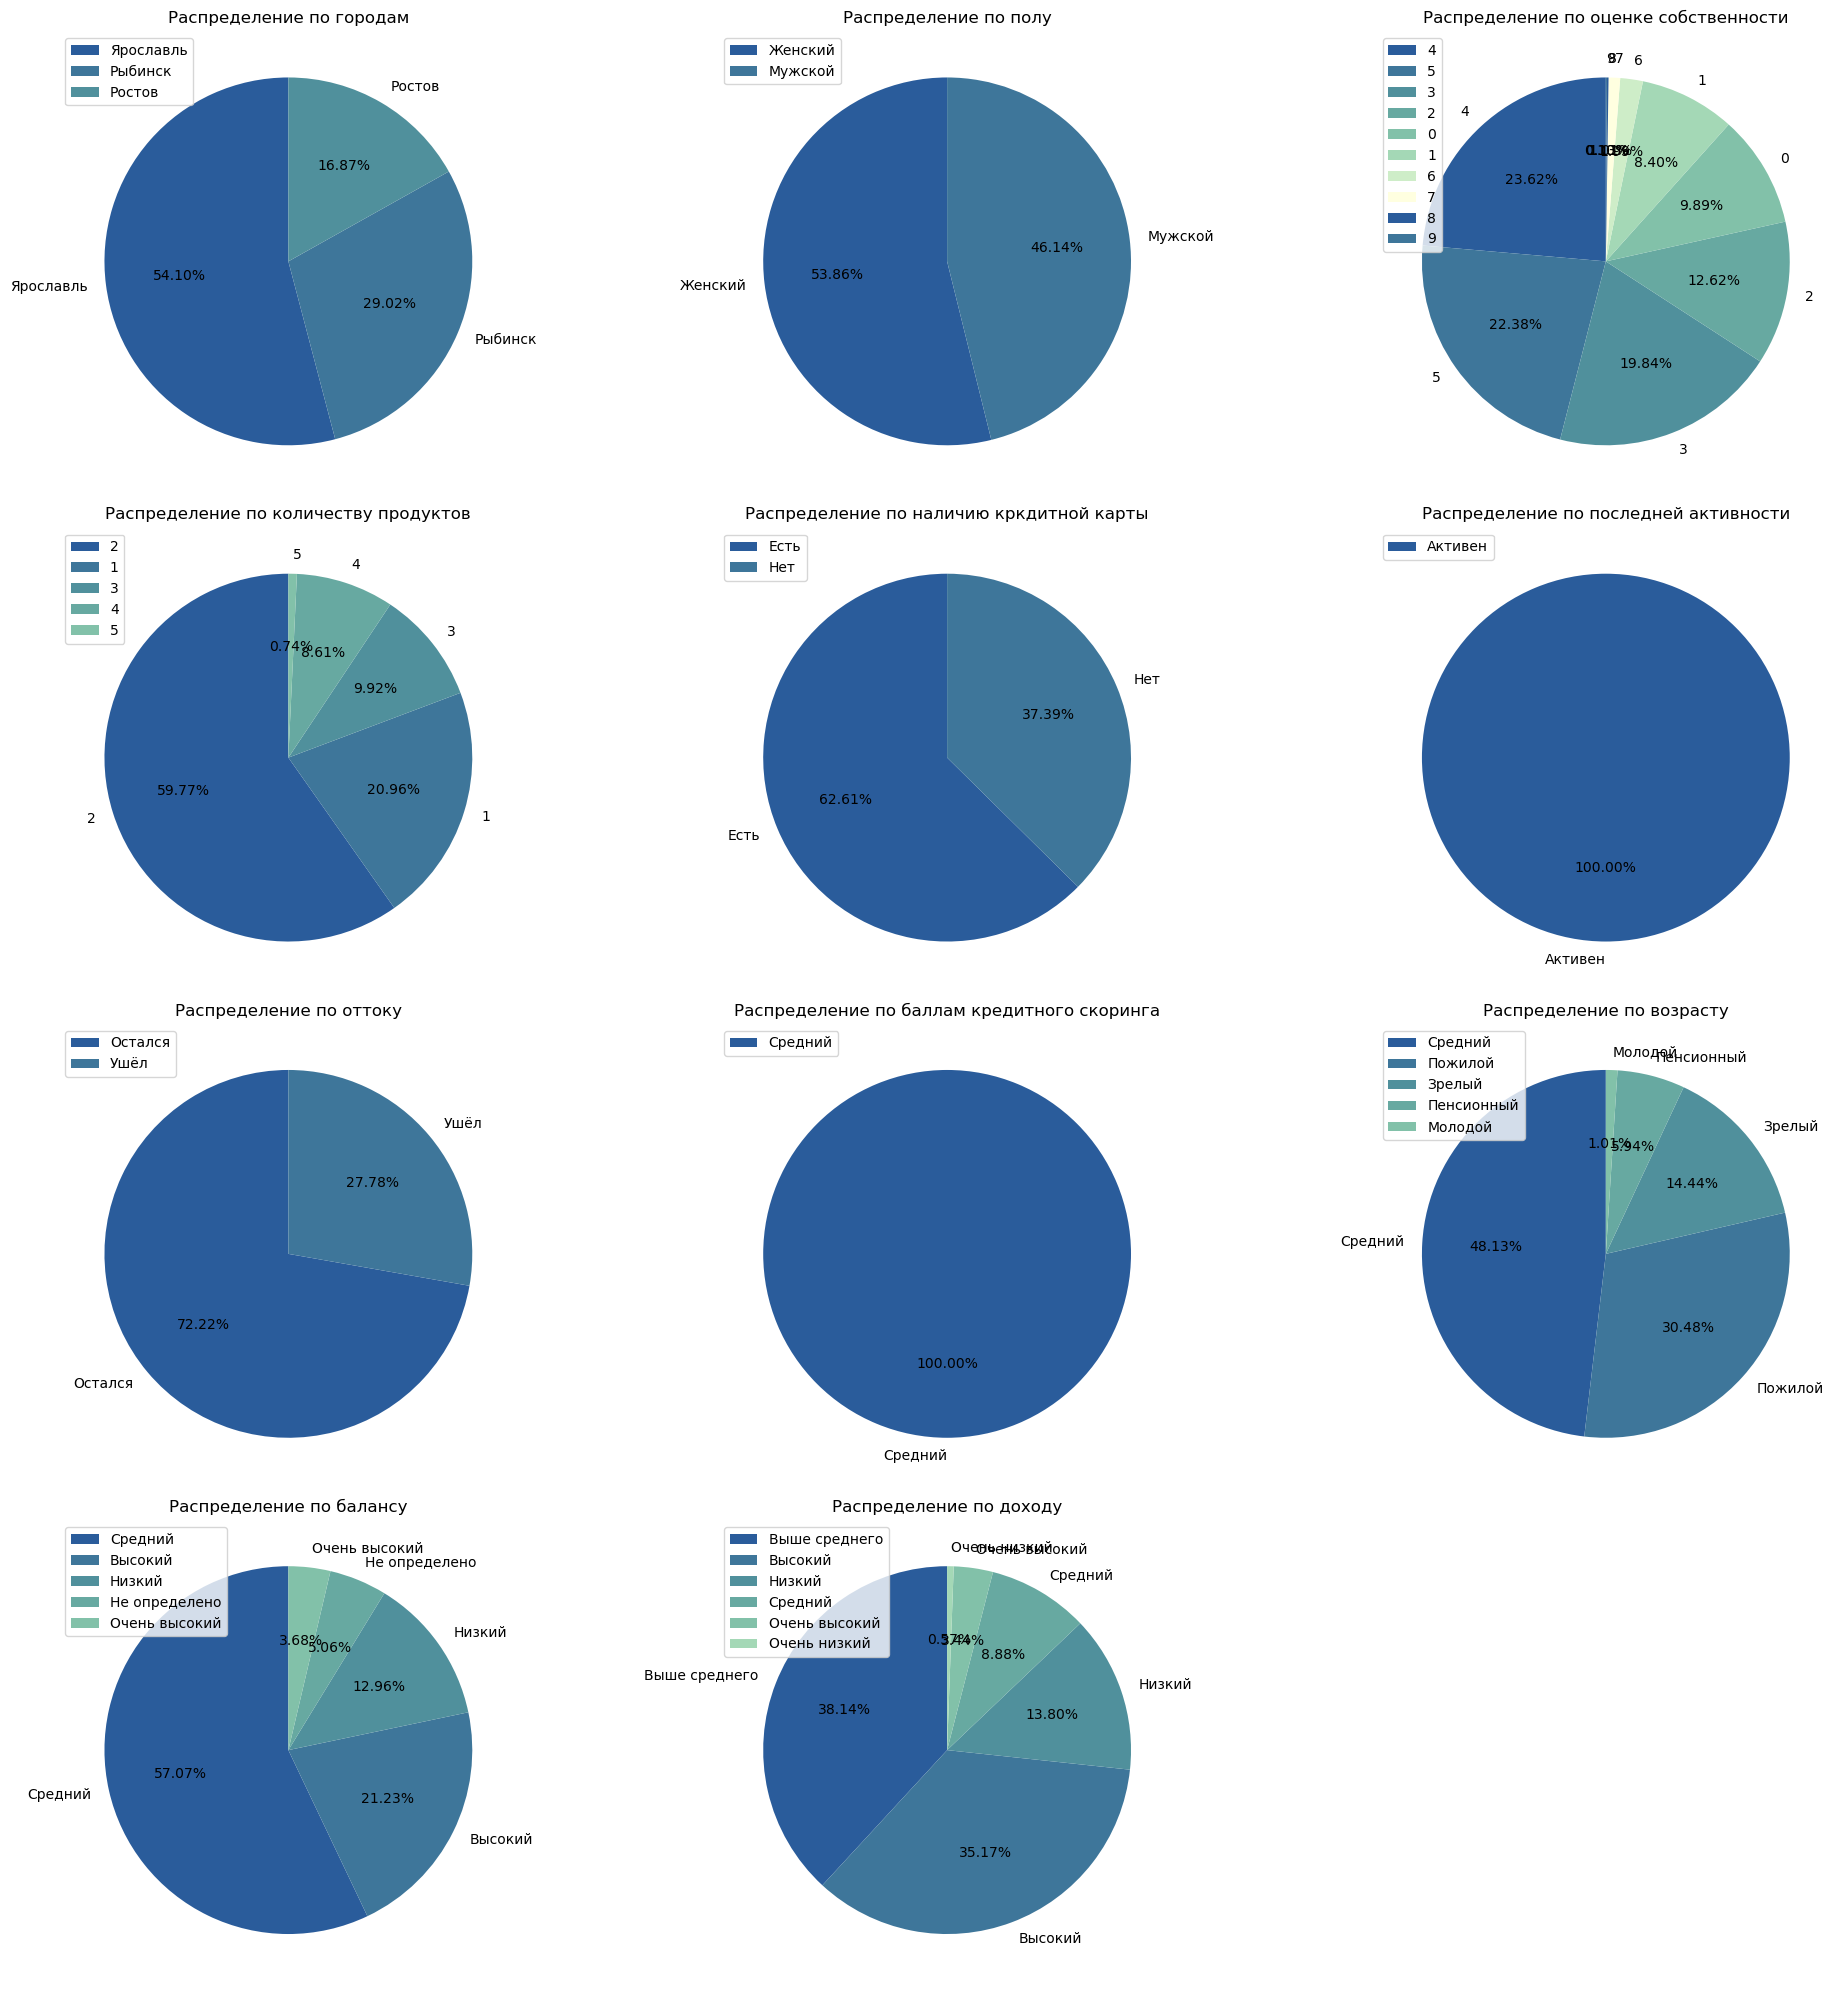

In [55]:
df_3 = df_eda.query('(last_activity == "Активен") and (score_level == "Средний")')
data(df_3)

In [56]:
print(
    f'Из данного сегмента ушли {df_3[df_3["churn"] == "Ушёл"]["userid"].nunique()} клиента.',
    f'Это составляет {"{0:.2f}".format(df_3[df_3["churn"] == "Ушёл"]["userid"].nunique() / df_eda[df_eda["churn"] == "Ушёл"]["userid"].nunique()*100)}% от общего числа ушедших.'
)

Из данного сегмента ушли 823 клиента. Это составляет 45.19% от общего числа ушедших.


### Сегмент 4: Клиенты с двумя банковскими продуктами и высоким уровнем баланса.

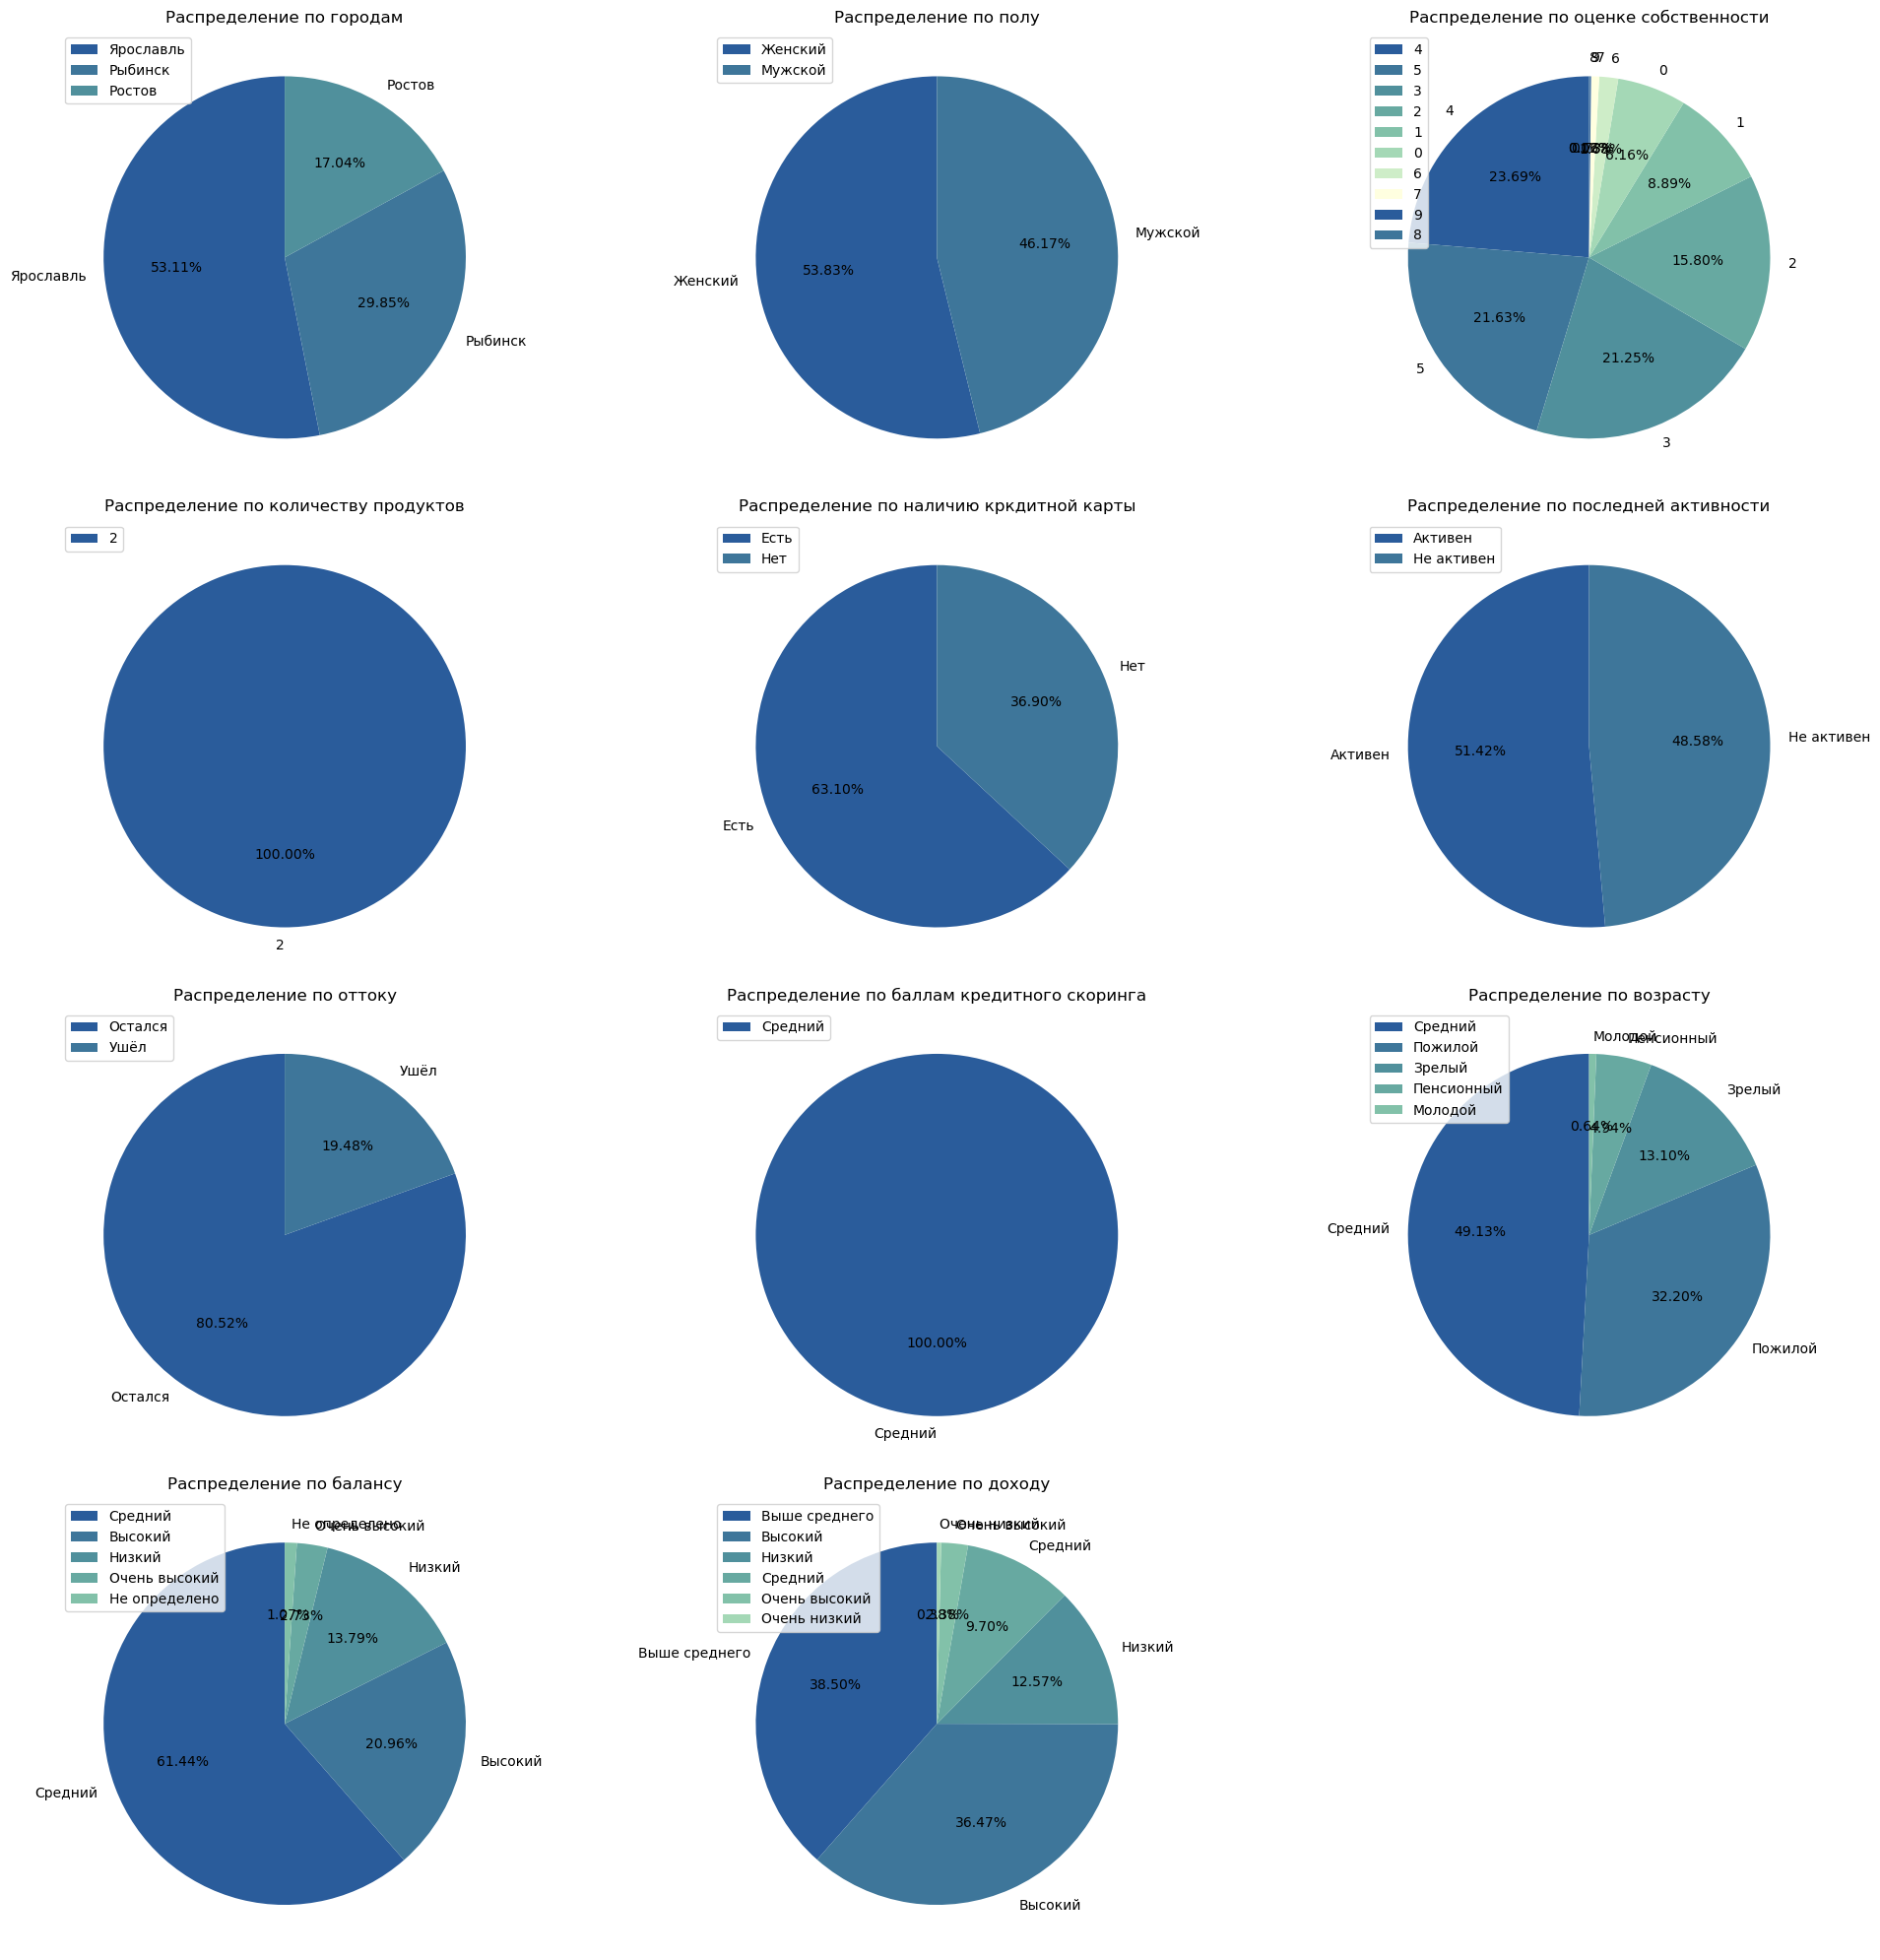

In [57]:
df_4 = df_eda.query('(products == 2) and (score_level == "Средний")')
data(df_4)

In [58]:
print(
    f'Из данного сегмента ушли {df_4[df_4["churn"] == "Ушёл"]["userid"].nunique()} клиент.',
    f'Это составляет {"{0:.2f}".format(df_4[df_4["churn"] == "Ушёл"]["userid"].nunique() / df_eda[df_eda["churn"] == "Ушёл"]["userid"].nunique()*100)}% от общего числа ушедших.'
)

Из данного сегмента ушли 671 клиент. Это составляет 36.85% от общего числа ушедших.


Вывод: Выделили 4 сегмента с наибольшим оттоком.
- Сегмент 1. Клиенты из г. Ярославль с средним уровнем баллов кредитного скоринга. Отток из данного сегмента составляет 712 клиентов. Это 39.12% от общего числа ушедших. 
- Сегмент 2. Клиенты мужского пола с средним уровнем баллов кредитного скоринга. Отток из данного сегмента составляет 759 клиентов. Это 41.70% от общего числа ушедших.
- Сегмент 3. Активные клиенты с средним уровнем баллов кредитного скоринга. Отток из данного сегмента составляет 823 клиента. Это 45.22% от общего числа ушедших.
- Сегмент 4. Клиенты с двумя банковскими продуктами и высоким уровнем баланса. Отток из данного сегмента усоставляет 671 клиент. Это 36.87% от общего числа ушедших.

## Выводы

1. Изучили данные: всего 10 000 строк, 12 столбцов.
    - userid — идентификатор пользователя,
    - score — баллы кредитного скоринга,
    - city — город,
    - gender — пол,
    - age — возраст,
    - equity — приблизительная оценка собственности клиента,
    - balance — баланс на счёте,
    - products — количество продуктов, которыми пользуется клиент,
    - credit_card — есть ли кредитная карта,
    - last_activity — был ли клиент активен последнее время,
    - est_salary — заработная плата клиента
    - churn — уходит или нет.

2. Проверили на наличие дубликатов - нашли и удалили 1.

3. Проверили на наличие пропусков: в столбце balance 22.95% пропусков. Принято решение не удалять эти строки.

4. Изучили столбцы и очистили от выбросов. При этом потеряли 0.74% информации.

5. Сгруппировали клиентов по баллам кредитного скоринга:
    - менее 770 -  Плохой
    - 770 - 890 -  Средний
    - 890 - 950 -  Хороший
    - 950 - 1000 - Очень хороший

6. Сгруппировали клиентов по возрасту:
    - 18 - 22 -  Молодой возраст
    - 22 - 30 -  Зрелый возраст
    - 30 - 45 -  Средний возраст
    - 45 - 65 -  Пожилой возраст
    - более 65 - Пенсионный возраст

7. Сгруппировали клиентов по балансу на счетах:
    - менее 200 000 -  Низкий
    - 200 000 - 800 000 -  Средний
    - 800 000 - 1 500 000 -  Высокий
    - более 1 500 000 -  Очень высокий

8. Сгруппировали клиентов по доходу:
    - менее 13 000 -  Очень низкий
    - 13 000 - 45 000 -  Низкий
    - 45 000 - 60 000 -  Средний
    - 60 000 - 120 000 -  Выше среднего
    - 120 000 - 250 000 - Высокий
    - более 250 000 - Очень высокий

9. Изучили клиентов:
- Распределение клиентов по городам:
  - Ярославль - 59.09%
  - Рыбинск - 26.58%
  - Ростов - 14.33%
- Распределение клиентов по половому признаку - поровну
- Распределение клиентов по оценке собственности:
  - 0 - 25.69%
  - 5 - 19.29%
  - 4 - 18.59%
  - 3 - 15.42%
  - 2 - 10.56 %
- Распределение клиентов по количеству продуктов:
  - 2 - 51.26%
  - 1 - 33.20%
  - 3 - 10.46%
- Распределение клиентов по наличию кредитной карты:
  - Есть - 67.97%
  - Нет - 32.03%
- Распределение клиентов по последней активности:
  - Активен - 52.24%
  - Не активен - 47.76%
- Распределение клиентов по оттоку:
  - Остался - 81.65%
  - Ушёл - 18.35%
- Распределение клиентов по баллам кредитного скоринга:
  - Средний - 57.48%
  - Хороший - 27.00%
  - Плохой - 11.25%
- Распределение клиентов по возрасту:
  - Средний возраст - 51.30%
  - Пожилой возраст - 30.54%
  - Зрелый возраст - 12.68%
- Распределение клиентов по балансу:
  - Средний - 41.31%
  - Не определено - 22.68%
  - Высокий - 17.95%
- Распределение по доходу:
  - Высокий - 40.90%
  - Выше среднего - 33.25%
  - Низкий - 9.35%

10. Изучили ушедших клиентов:
- Распределение по городам:
  - Ярославль - 61.56%
  - Рыбинск - 24.35%
  - Ростов - 14.77%
- Распределение по половому признаку:
  - Мужской - 65.02%
  - Женский - 34.98%
- Распределение по оценке собственности:
  - 5 - 31.69%
  - 4 - 25.54%
  - 3 - 17.68%
  - 2 - 9.12 %
- Распределение по количеству продуктов:
  - 2 - 53.76%
  - 4 - 16.47%
  - 3 - 16.36%
- Распределение по наличию кредитной карты:
  - Есть - 55.08%
  - Нет - 44.92%
- Распределение по последней активности:
  - Активен - 70.29%
  - Не активен - 29.71%
- Распределение по баллам кредитного скоринга:
  - Средний - 65.13%
  - Хороший - 28.61%
  - Плохой - 3.24%
- Распределение по возрасту:
  - Средний возраст - 48.05%
  - Пожилой возраст - 34.54%
  - Зрелый возраст - 16.14%
- Распределение по балансу:
  - Средний - 41.30%
  - Высокий- 29.00%
  - Низкий - 19.77%
- Распределение по доходу:
  - Высокий - 44.21%
  - Выше среднего - 33.22%
  - Очень высокий - 8.84%

11. Проверили корреляцию по Спирмену - зависимости не обнаружены.

12. Проверили гипотезы:
    - Значимых различий между средними доходами у клиентов оставшихся и ушедших нет
    - Есть значимые различия между средними баллами кредитного скоринга у тех, кто ушел и тех, кто остался
13. Выделил 4 категории клиентов:
    1) Сегмент 1. Клиенты из г. Ярославль с средним уровнем баллов кредитного скоринга. Отток из данного сегмента                  составляет 712 клиентов. Это 39.12% от общего числа ушедших. 
    2) Сегмент 2. Клиенты мужского пола с средним уровнем баллов кредитного скоринга. Отток из данного сегмента составляет        759 клиентов. Это 41.70% от общего числа ушедших.
    3) Сегмент 3. Активные клиенты с средним уровнем баллов кредитного скоринга. Отток из данного сегмента составляет 823          клиента. Это 45.22% от общего числа ушедших.
    4) Сегмент 4. Клиенты с двумя банковскими продуктами и высоким уровнем баланса. Отток из данного сегмента усоставляет         671 клиент. Это 36.87% от общего числа ушедших.


`Рекомендации:` Необходимо предпринять действия в адрес клиентов с средним уровнем баллов кредитного скоринга (770-890) из Ярославского отделения или активных клиентов с тем же уровнем баллов. Также обратить внимание на клиентов с двумя банковскими продуктами и высоким уровнем баланса.   